# Cross model predictions

This notebook discusses predictions made on datasets for which it has not been trained. This includes using models trained for dataset D to predict on dataset F and G, models trained on dataset F to predict on datset D and G, and so on.

The stateless version of the API is used in order to provide more flexibility. For the stateless API, additional returned variables such as *maxEnrolWindow* and *indexColumn* not present in the simpler notebooks can be seen. The functionality of this notebook exceeds the primary intents for the high-level API, and thus does not follow the same recipe as the *basic examples*. Understanding of the implemented python methods is not required in order to interpret the results, and therefore the implementation is not discussed in detail.

## Step 0: Import modules

In [1]:
# %load cross_model_predictions.py
import src.core_stateless as statelessApi
import src.core_configs as configs

Using TensorFlow backend.


## Step 1: Implement required methods

A method is implemented to fetch configs, define models and make predictions based on a directory, model and resolution as input parameters. Each combination of these three parameters provides a predefinend set of dataset specifics found in the *src.core_configs* file.

In [2]:
def trainModelsWithConfig(dirr, mod, res):
	filename, columns, irrelevantColumns, targetColumns, traintime, testtime, columnOrder = configs.getConfig(dirr, mod, res)

	relevantColumns, columnDescriptions, columnUnits, columnNames, df = statelessApi.initDataframe(filename, columns, irrelevantColumns)
	df = df[columnOrder]
	df_train, df_test = statelessApi.getTestTrainSplit(df, traintime, testtime)
	X_train, y_train, X_test, y_test = statelessApi.getFeatureTargetSplit(df_train, df_test, targetColumns)

	mlpd_2x_64 = statelessApi.MLP('mlpd 2x64 ' + dirr + ' ' + mod + ' ' + res, X_train, y_train, layers=[64, 64], dropout=0.2)
	lstmd_2x_64 = statelessApi.LSTM('lstmd 2x64 ' + dirr + ' ' + mod + ' ' + res, X_train, y_train, layers=[64, 64], dropout=0.2, recurrentDropout=0.2)
	linear_r = statelessApi.Linear_Regularized('linear ' + dirr + ' ' + mod + ' ' + res, X_train, y_train)

	modelList = [
		mlpd_2x_64,
		lstmd_2x_64,
		linear_r,
	]

	retrain=False

	maxEnrolWindow, indexColumn = statelessApi.initModels(modelList, df_test)
	statelessApi.trainModels(modelList, filename, targetColumns, retrain)

	return modelList

A method is implemented to predict with a provided config for a provided model list. Because each defined model is initiated with its own input and output scaler based on the provided training data, these scalers must be redefined for each time predictions with a different dataset are to be made. Following this, predictions are made and plotted.

In [3]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def predictWithConfig(modelList, dirr, mod, res):
	filename, columns, irrelevantColumns, targetColumns, traintime, testtime, columnOrder = configs.getConfig(dirr, mod, res)

	relevantColumns, columnDescriptions, columnUnits, columnNames, df = statelessApi.initDataframe(filename, columns, irrelevantColumns)
	df = df[columnOrder]
	df_train, df_test = statelessApi.getTestTrainSplit(df, traintime, testtime)
	X_train, y_train, X_test, y_test = statelessApi.getFeatureTargetSplit(df_train, df_test, targetColumns)
	maxEnrolWindow, indexColumn = statelessApi.initModels(modelList, df_test)

	inputScaler = StandardScaler()
	inputScaler.fit(X_train)
	outputScaler = StandardScaler()
	outputScaler.fit(y_train)

	for model in modelList:
		model.inputScaler = inputScaler
		model.outputScaler = outputScaler

	modelNames, metrics_train, metrics_test, columnsList, deviationsList = statelessApi.predictWithModels(
		modelList,
		X_train,
		y_train,
		X_test,
		y_test,
		targetColumns,
		indexColumn,
		columnDescriptions,
		columnUnits,
		traintime,
		plot=True,
		interpol=False,
	)

## Step 2: Define directories, models and resolution to be used for predictions

The three datasets *D*, *F* and *G* are chosen. The models *A* and *B* as defined in the thesis are chosen as well. A resolution of 30min is chosen. Do note that this resolution will not be used for the *D* dataset as this only offers 6 hour prediction intervals.

In [4]:
dirrs = ['D', 'F', 'G']
mods = ['A', 'B']
res = '30min'

## Step 3: Loop the desired prediction models (A and B), and make predictions for each dataset.

Predictions are made in bulks in order to increase the readability of the output, using the below function for each pair of (Model, Dataset). Note that the model parameter is called *mod* and the Dataset paramter is called *dirr*.

In [ ]:
def makePredictionsForModAndDir(mod, dirr, dirrs, res):
    allModels = []
    for dirrr in dirrs:
        print("")
        print("Training/loading models for dataset " + dirrr)
        print("Model " + mod)
        print("Resolution " + res)
        print("")
        modelList = trainModelsWithConfig(dirrr, mod, res)
        allModels.append(modelList)

    for i in range(len(allModels)):
        modelsOfTypei = list(map(lambda x : x[i], allModels))
        print("")
        print("Predictions and deviations for dataset " + dirr)
        print("Model " + mod)
        print("Resolution " + res)
        print("")
        predictWithConfig(modelsOfTypei, dirr, mod, res)


Training/loading models for dataset D
Model A
Resolution 30min

Columns before removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20PT001 - Process Inlet Pressure
Col. 2 : 20FT001 - Process Flow Rate
Col. 3 : 20TT002 - Process Outlet Temperature
Col. 4 : 20PDT001 - Process Pressure Difference
Col. 5 : 50TT001 - Coolant Inlet Temperature
Col. 6 : 50PT001 - Coolant Inlet Pressure
Col. 7 : 50FT001 - Coolant Flow Rate
Col. 8 : 50TT002 - Coolant Outlet Temperature
Col. 9 : 50PDT001 - Coolant Pressure Difference
Col. 10 : 50TV001 - Coolant Valve Opening

Columns after removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20FT001 - Process Flow Rate
Col. 2 : 20TT002 - Process Outlet Temperature
Col. 3 : 50TT001 - Coolant Inlet Temperature
Col. 4 : 50TT002 - Coolant Outlet Temperature

Finding data between 2020-01-01 00:00:00 and 2020-03-20 00:00:00
Found 315 rows

Finding data between 2020-01-01 00:00:00 and 2020-08-01 00:00:00
Found 726 rows

Model mlpd 2x64 D A 30min

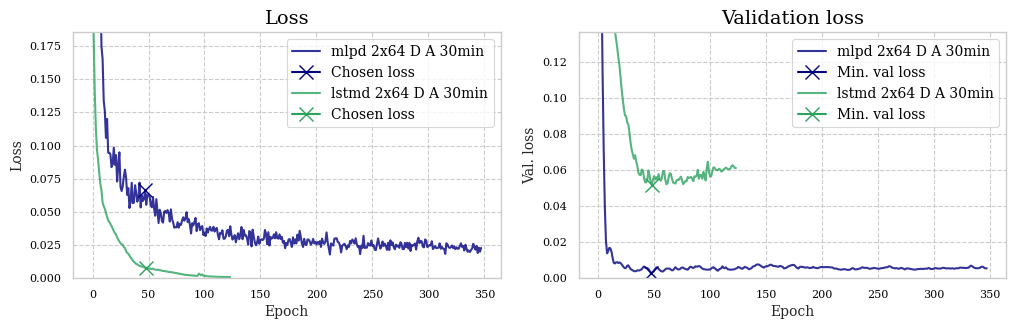


Training/loading models for dataset F
Model A
Resolution 30min

Columns before removal: 
Col. 0 : FYN0111 - Process Flow Rate
Col. 1 : TT0102_MA_Y - Process Inlet Temperature A
Col. 2 : TIC0101_CA_YX - Process Outlet Temperature A
Col. 3 : TT0104_MA_Y - Process Inlet Temperature B
Col. 4 : TIC0103_CA_YX - Process Outlet Temperature B
Col. 5 : TT0106_MA_Y - Process Inlet Temperature C
Col. 6 : TIC0105_CA_YX - Process Outlet Temperature C
Col. 7 : PDT0108_MA_Y - Process A Pressure Difference
Col. 8 : PDT0119_MA_Y - Process B Pressure Difference
Col. 9 : PDT0118_MA_Y - Process C Pressure Difference
Col. 10 : PIC0104_CA_YX - Separator Inlet Pressure
Col. 11 : TIC0425_CA_YX - Coolant Inlet Temperature
Col. 12 : TT0651_MA_Y - Coolant Outlet Temperature A
Col. 13 : TT0652_MA_Y - Coolant Outlet Temperature B
Col. 14 : TT0653_MA_Y - Coolant Outlet Temperature C
Col. 15 : TIC0101_CA_Y - Coolant Valve Opening A
Col. 16 : TIC0103_CA_Y - Coolant Valve Opening B
Col. 17 : TIC0105_CA_Y - Coolant Val

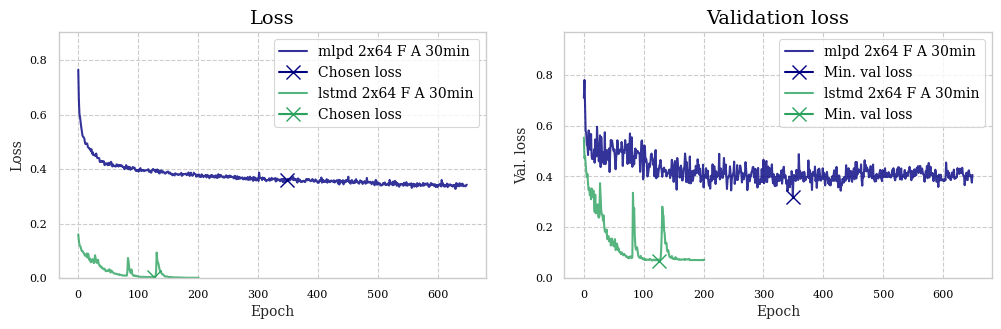


Training/loading models for dataset G
Model A
Resolution 30min

Columns before removal: 
Col. 0 : PDI0064 - Process Pressure Difference
Col. 1 : TI0066 - Process Outlet Temperature
Col. 2 : TZI0012 - Process Inlet Temperature
Col. 3 : FI0010 - Process Flow Rate
Col. 4 : TT0025 - Coolant Inlet Temperature
Col. 5 : TT0026 - Coolant Outlet Temperature
Col. 6 : PI0001 - Coolant Inlet Pressure
Col. 7 : FI0027 - Coolant Flow Rate
Col. 8 : TIC0022U - Coolant Valve Opening
Col. 9 : PDT0024 - Coolant Pressure Difference

Columns after removal: 
Col. 0 : TI0066 - Process Outlet Temperature
Col. 1 : TZI0012 - Process Inlet Temperature
Col. 2 : FI0010 - Process Flow Rate
Col. 3 : TT0025 - Coolant Inlet Temperature
Col. 4 : TT0026 - Coolant Outlet Temperature

Finding data between 2019-04-10 00:00:00 and 2019-08-01 00:00:00
Found 4708 rows

Finding data between 2017-01-01 00:00:00 and 2020-03-01 00:00:00
Found 49290 rows

Model mlpd 2x64 G A 30min was loaded from file
Model lstmd 2x64 G A 30min wa

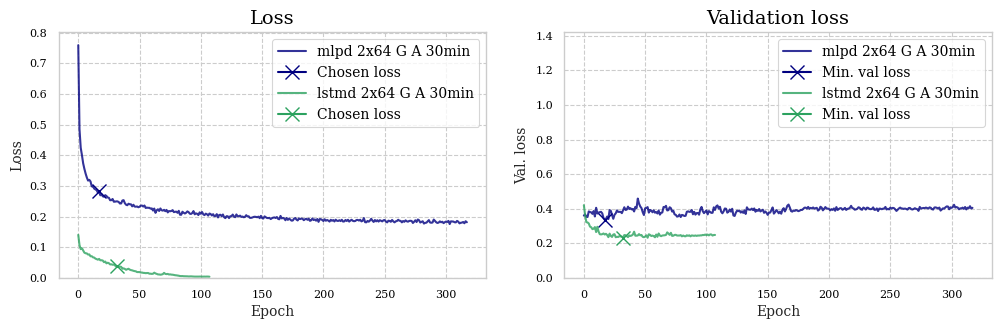


Predictions and deviations for dataset D
Model A
Resolution 30min

Columns before removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20PT001 - Process Inlet Pressure
Col. 2 : 20FT001 - Process Flow Rate
Col. 3 : 20TT002 - Process Outlet Temperature
Col. 4 : 20PDT001 - Process Pressure Difference
Col. 5 : 50TT001 - Coolant Inlet Temperature
Col. 6 : 50PT001 - Coolant Inlet Pressure
Col. 7 : 50FT001 - Coolant Flow Rate
Col. 8 : 50TT002 - Coolant Outlet Temperature
Col. 9 : 50PDT001 - Coolant Pressure Difference
Col. 10 : 50TV001 - Coolant Valve Opening

Columns after removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20FT001 - Process Flow Rate
Col. 2 : 20TT002 - Process Outlet Temperature
Col. 3 : 50TT001 - Coolant Inlet Temperature
Col. 4 : 50TT002 - Coolant Outlet Temperature

Finding data between 2020-01-01 00:00:00 and 2020-03-20 00:00:00
Found 315 rows

Finding data between 2020-01-01 00:00:00 and 2020-08-01 00:00:00
Found 726 rows

Model prediction score

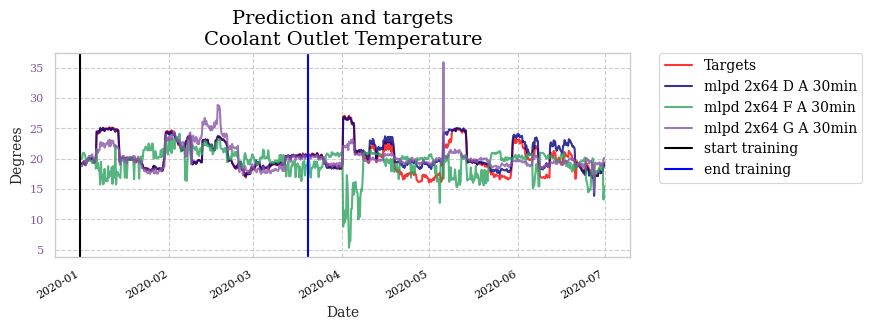

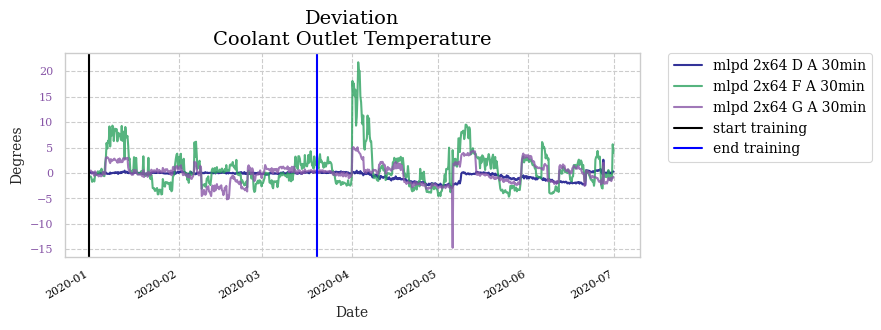

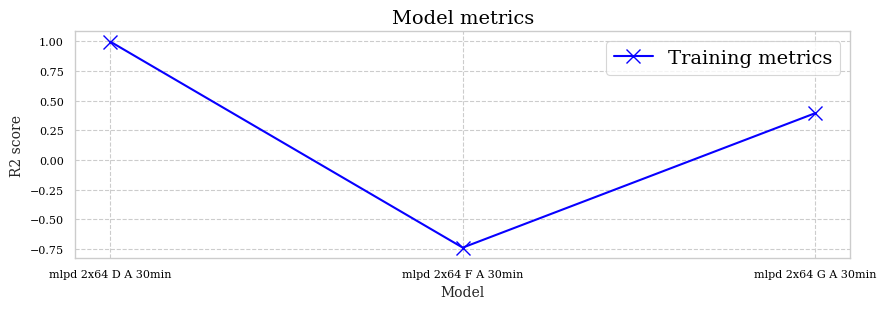


Predictions and deviations for dataset D
Model A
Resolution 30min

Columns before removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20PT001 - Process Inlet Pressure
Col. 2 : 20FT001 - Process Flow Rate
Col. 3 : 20TT002 - Process Outlet Temperature
Col. 4 : 20PDT001 - Process Pressure Difference
Col. 5 : 50TT001 - Coolant Inlet Temperature
Col. 6 : 50PT001 - Coolant Inlet Pressure
Col. 7 : 50FT001 - Coolant Flow Rate
Col. 8 : 50TT002 - Coolant Outlet Temperature
Col. 9 : 50PDT001 - Coolant Pressure Difference
Col. 10 : 50TV001 - Coolant Valve Opening

Columns after removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20FT001 - Process Flow Rate
Col. 2 : 20TT002 - Process Outlet Temperature
Col. 3 : 50TT001 - Coolant Inlet Temperature
Col. 4 : 50TT002 - Coolant Outlet Temperature

Finding data between 2020-01-01 00:00:00 and 2020-03-20 00:00:00
Found 315 rows

Finding data between 2020-01-01 00:00:00 and 2020-08-01 00:00:00
Found 726 rows

Model prediction score

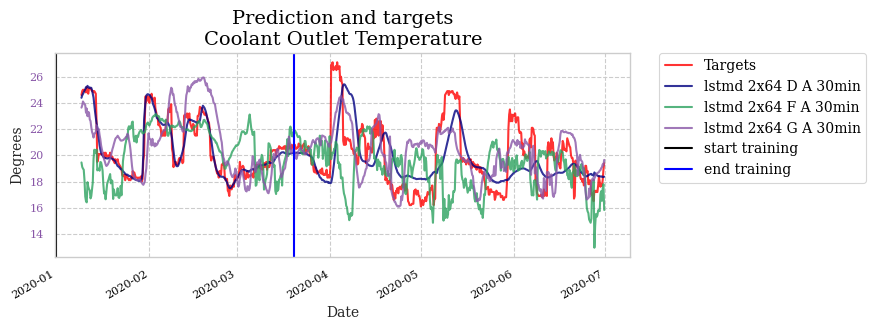

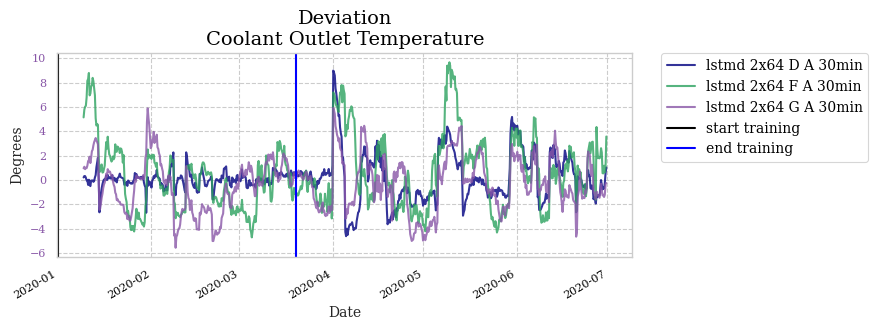

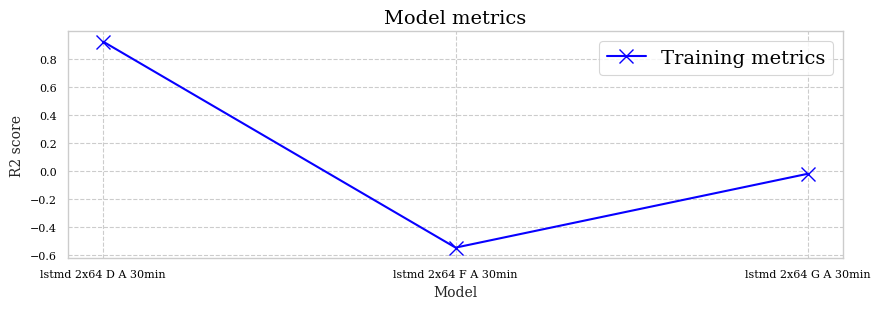


Predictions and deviations for dataset D
Model A
Resolution 30min

Columns before removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20PT001 - Process Inlet Pressure
Col. 2 : 20FT001 - Process Flow Rate
Col. 3 : 20TT002 - Process Outlet Temperature
Col. 4 : 20PDT001 - Process Pressure Difference
Col. 5 : 50TT001 - Coolant Inlet Temperature
Col. 6 : 50PT001 - Coolant Inlet Pressure
Col. 7 : 50FT001 - Coolant Flow Rate
Col. 8 : 50TT002 - Coolant Outlet Temperature
Col. 9 : 50PDT001 - Coolant Pressure Difference
Col. 10 : 50TV001 - Coolant Valve Opening

Columns after removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20FT001 - Process Flow Rate
Col. 2 : 20TT002 - Process Outlet Temperature
Col. 3 : 50TT001 - Coolant Inlet Temperature
Col. 4 : 50TT002 - Coolant Outlet Temperature

Finding data between 2020-01-01 00:00:00 and 2020-03-20 00:00:00
Found 315 rows

Finding data between 2020-01-01 00:00:00 and 2020-08-01 00:00:00
Found 726 rows

Model prediction score

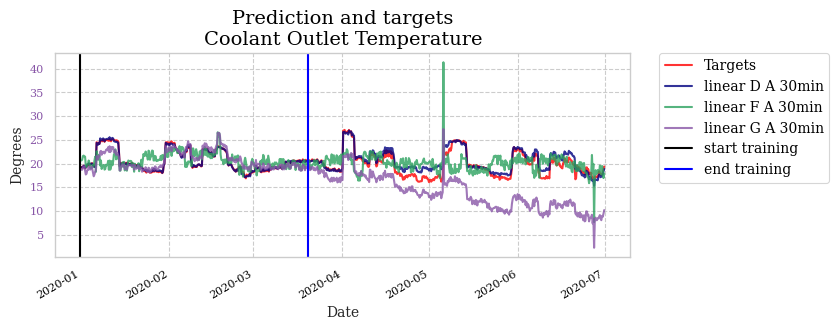

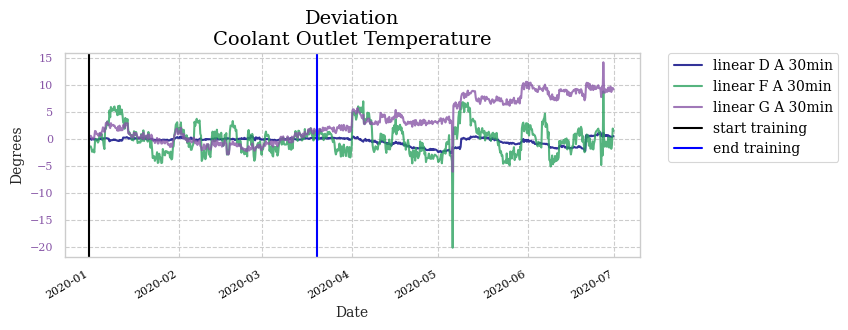

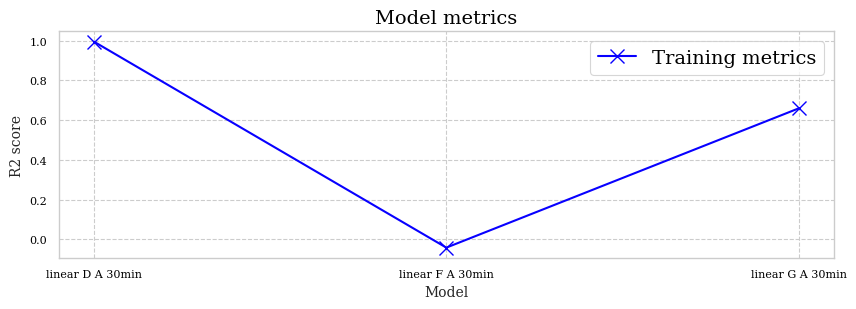

In [5]:
makePredictionsForModAndDir('A', 'D', dirrs, res)

## Discussion, Dataset D, model A

Non of the models trained on different datasets generalize to use for dataset D. Even though the R2-score calculated on the training set is acceptable at times, it becomes apparent by looking at the plots that the predictions do not follow the expected fouling pattern.


Training/loading models for dataset D
Model A
Resolution 30min

Columns before removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20PT001 - Process Inlet Pressure
Col. 2 : 20FT001 - Process Flow Rate
Col. 3 : 20TT002 - Process Outlet Temperature
Col. 4 : 20PDT001 - Process Pressure Difference
Col. 5 : 50TT001 - Coolant Inlet Temperature
Col. 6 : 50PT001 - Coolant Inlet Pressure
Col. 7 : 50FT001 - Coolant Flow Rate
Col. 8 : 50TT002 - Coolant Outlet Temperature
Col. 9 : 50PDT001 - Coolant Pressure Difference
Col. 10 : 50TV001 - Coolant Valve Opening

Columns after removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20FT001 - Process Flow Rate
Col. 2 : 20TT002 - Process Outlet Temperature
Col. 3 : 50TT001 - Coolant Inlet Temperature
Col. 4 : 50TT002 - Coolant Outlet Temperature

Finding data between 2020-01-01 00:00:00 and 2020-03-20 00:00:00
Found 315 rows

Finding data between 2020-01-01 00:00:00 and 2020-08-01 00:00:00
Found 726 rows

Model mlpd 2x64 D A 30min

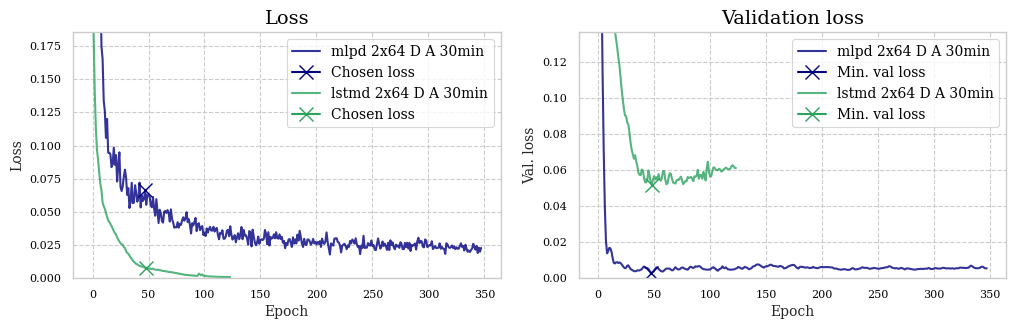


Training/loading models for dataset F
Model A
Resolution 30min

Columns before removal: 
Col. 0 : FYN0111 - Process Flow Rate
Col. 1 : TT0102_MA_Y - Process Inlet Temperature A
Col. 2 : TIC0101_CA_YX - Process Outlet Temperature A
Col. 3 : TT0104_MA_Y - Process Inlet Temperature B
Col. 4 : TIC0103_CA_YX - Process Outlet Temperature B
Col. 5 : TT0106_MA_Y - Process Inlet Temperature C
Col. 6 : TIC0105_CA_YX - Process Outlet Temperature C
Col. 7 : PDT0108_MA_Y - Process A Pressure Difference
Col. 8 : PDT0119_MA_Y - Process B Pressure Difference
Col. 9 : PDT0118_MA_Y - Process C Pressure Difference
Col. 10 : PIC0104_CA_YX - Separator Inlet Pressure
Col. 11 : TIC0425_CA_YX - Coolant Inlet Temperature
Col. 12 : TT0651_MA_Y - Coolant Outlet Temperature A
Col. 13 : TT0652_MA_Y - Coolant Outlet Temperature B
Col. 14 : TT0653_MA_Y - Coolant Outlet Temperature C
Col. 15 : TIC0101_CA_Y - Coolant Valve Opening A
Col. 16 : TIC0103_CA_Y - Coolant Valve Opening B
Col. 17 : TIC0105_CA_Y - Coolant Val

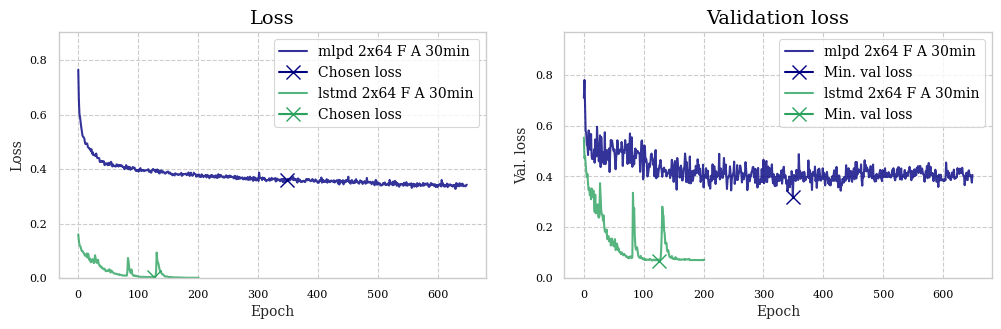


Training/loading models for dataset G
Model A
Resolution 30min

Columns before removal: 
Col. 0 : PDI0064 - Process Pressure Difference
Col. 1 : TI0066 - Process Outlet Temperature
Col. 2 : TZI0012 - Process Inlet Temperature
Col. 3 : FI0010 - Process Flow Rate
Col. 4 : TT0025 - Coolant Inlet Temperature
Col. 5 : TT0026 - Coolant Outlet Temperature
Col. 6 : PI0001 - Coolant Inlet Pressure
Col. 7 : FI0027 - Coolant Flow Rate
Col. 8 : TIC0022U - Coolant Valve Opening
Col. 9 : PDT0024 - Coolant Pressure Difference

Columns after removal: 
Col. 0 : TI0066 - Process Outlet Temperature
Col. 1 : TZI0012 - Process Inlet Temperature
Col. 2 : FI0010 - Process Flow Rate
Col. 3 : TT0025 - Coolant Inlet Temperature
Col. 4 : TT0026 - Coolant Outlet Temperature

Finding data between 2019-04-10 00:00:00 and 2019-08-01 00:00:00
Found 4708 rows

Finding data between 2017-01-01 00:00:00 and 2020-03-01 00:00:00
Found 49290 rows

Model mlpd 2x64 G A 30min was loaded from file
Model lstmd 2x64 G A 30min wa

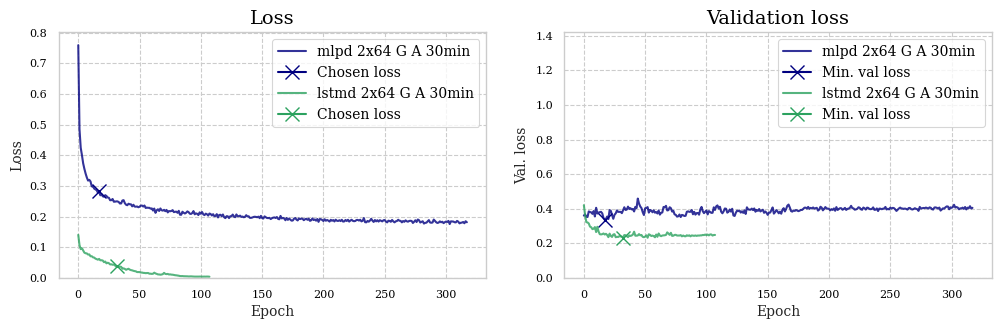


Predictions and deviations for dataset F
Model A
Resolution 30min

Columns before removal: 
Col. 0 : FYN0111 - Process Flow Rate
Col. 1 : TT0102_MA_Y - Process Inlet Temperature A
Col. 2 : TIC0101_CA_YX - Process Outlet Temperature A
Col. 3 : TT0104_MA_Y - Process Inlet Temperature B
Col. 4 : TIC0103_CA_YX - Process Outlet Temperature B
Col. 5 : TT0106_MA_Y - Process Inlet Temperature C
Col. 6 : TIC0105_CA_YX - Process Outlet Temperature C
Col. 7 : PDT0108_MA_Y - Process A Pressure Difference
Col. 8 : PDT0119_MA_Y - Process B Pressure Difference
Col. 9 : PDT0118_MA_Y - Process C Pressure Difference
Col. 10 : PIC0104_CA_YX - Separator Inlet Pressure
Col. 11 : TIC0425_CA_YX - Coolant Inlet Temperature
Col. 12 : TT0651_MA_Y - Coolant Outlet Temperature A
Col. 13 : TT0652_MA_Y - Coolant Outlet Temperature B
Col. 14 : TT0653_MA_Y - Coolant Outlet Temperature C
Col. 15 : TIC0101_CA_Y - Coolant Valve Opening A
Col. 16 : TIC0103_CA_Y - Coolant Valve Opening B
Col. 17 : TIC0105_CA_Y - Coolant 

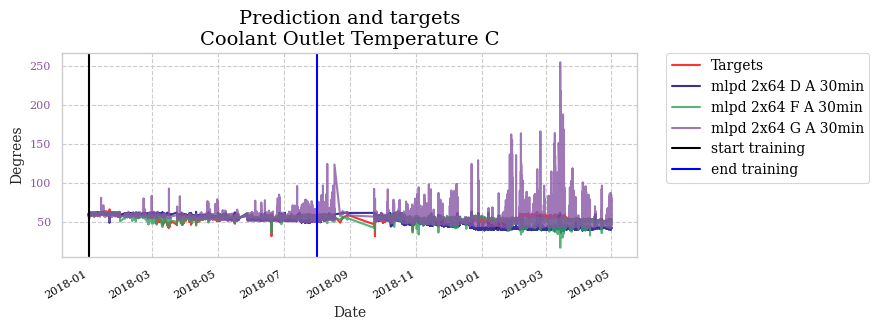

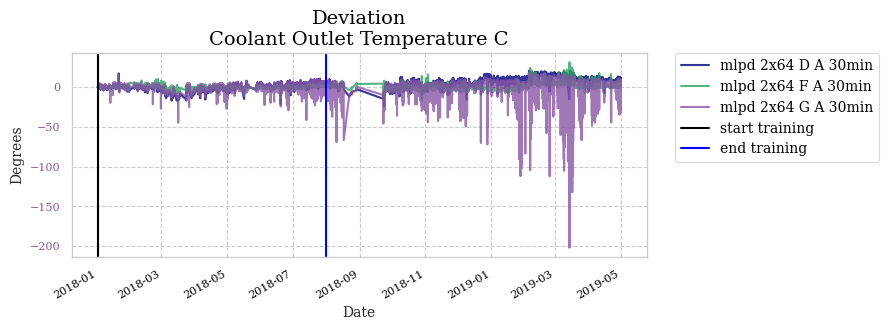

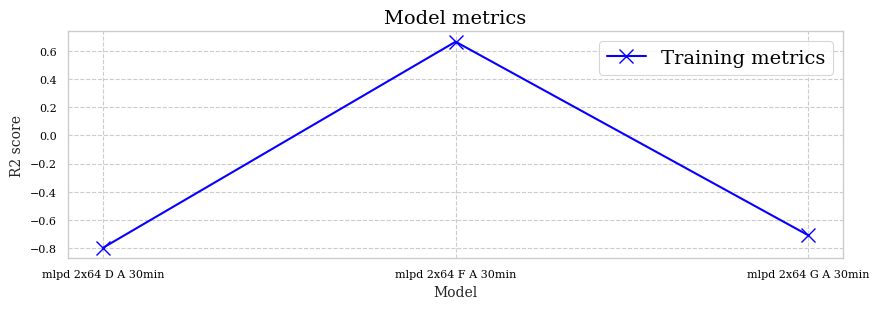


Predictions and deviations for dataset F
Model A
Resolution 30min

Columns before removal: 
Col. 0 : FYN0111 - Process Flow Rate
Col. 1 : TT0102_MA_Y - Process Inlet Temperature A
Col. 2 : TIC0101_CA_YX - Process Outlet Temperature A
Col. 3 : TT0104_MA_Y - Process Inlet Temperature B
Col. 4 : TIC0103_CA_YX - Process Outlet Temperature B
Col. 5 : TT0106_MA_Y - Process Inlet Temperature C
Col. 6 : TIC0105_CA_YX - Process Outlet Temperature C
Col. 7 : PDT0108_MA_Y - Process A Pressure Difference
Col. 8 : PDT0119_MA_Y - Process B Pressure Difference
Col. 9 : PDT0118_MA_Y - Process C Pressure Difference
Col. 10 : PIC0104_CA_YX - Separator Inlet Pressure
Col. 11 : TIC0425_CA_YX - Coolant Inlet Temperature
Col. 12 : TT0651_MA_Y - Coolant Outlet Temperature A
Col. 13 : TT0652_MA_Y - Coolant Outlet Temperature B
Col. 14 : TT0653_MA_Y - Coolant Outlet Temperature C
Col. 15 : TIC0101_CA_Y - Coolant Valve Opening A
Col. 16 : TIC0103_CA_Y - Coolant Valve Opening B
Col. 17 : TIC0105_CA_Y - Coolant 

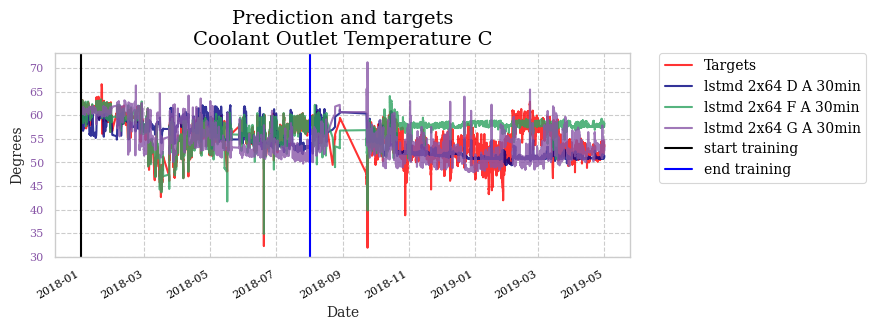

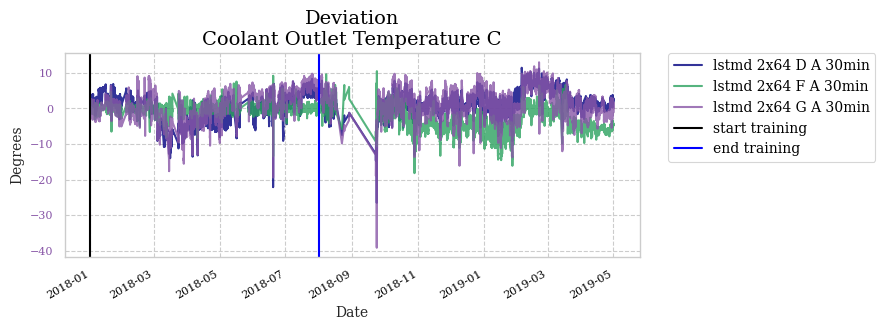

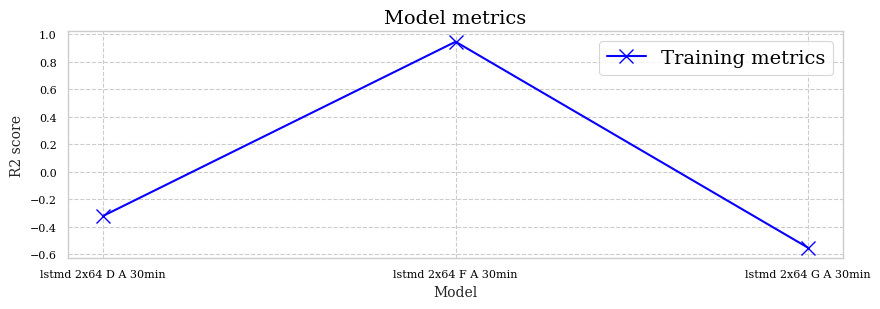


Predictions and deviations for dataset F
Model A
Resolution 30min

Columns before removal: 
Col. 0 : FYN0111 - Process Flow Rate
Col. 1 : TT0102_MA_Y - Process Inlet Temperature A
Col. 2 : TIC0101_CA_YX - Process Outlet Temperature A
Col. 3 : TT0104_MA_Y - Process Inlet Temperature B
Col. 4 : TIC0103_CA_YX - Process Outlet Temperature B
Col. 5 : TT0106_MA_Y - Process Inlet Temperature C
Col. 6 : TIC0105_CA_YX - Process Outlet Temperature C
Col. 7 : PDT0108_MA_Y - Process A Pressure Difference
Col. 8 : PDT0119_MA_Y - Process B Pressure Difference
Col. 9 : PDT0118_MA_Y - Process C Pressure Difference
Col. 10 : PIC0104_CA_YX - Separator Inlet Pressure
Col. 11 : TIC0425_CA_YX - Coolant Inlet Temperature
Col. 12 : TT0651_MA_Y - Coolant Outlet Temperature A
Col. 13 : TT0652_MA_Y - Coolant Outlet Temperature B
Col. 14 : TT0653_MA_Y - Coolant Outlet Temperature C
Col. 15 : TIC0101_CA_Y - Coolant Valve Opening A
Col. 16 : TIC0103_CA_Y - Coolant Valve Opening B
Col. 17 : TIC0105_CA_Y - Coolant 

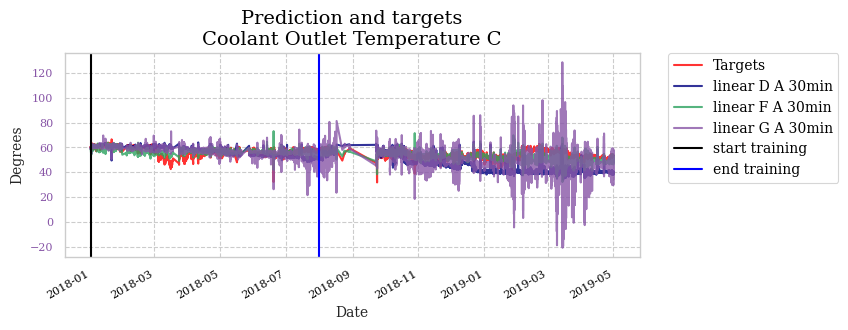

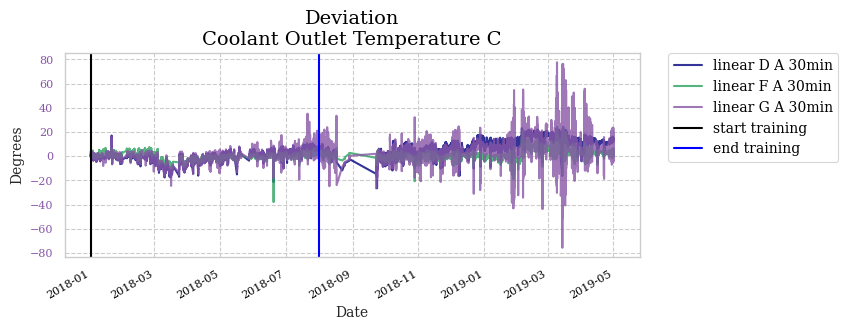

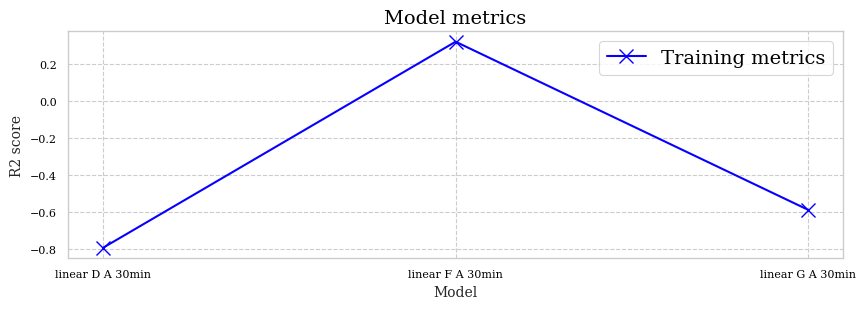

In [6]:
makePredictionsForModAndDir('A', 'F', dirrs, res)

## Discussion, Dataset F, model A

Non of the models trained on different datasets generalize to use for dataset D. Especially the models trained on dataset G show large variations when used to predict on dataset F. Interestingly, LSTM predictions with models trained on dataset D and F show the same lack of variation, while predictions with the model trained on dataset G varies greatly. It is difficult to determine which model is most appropriate without thorough analysis of the underlying data, and even then the model performance may not be explainable. Examining the model parameters is out of the question due to the amount of trainable weights.


Training/loading models for dataset D
Model A
Resolution 30min

Columns before removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20PT001 - Process Inlet Pressure
Col. 2 : 20FT001 - Process Flow Rate
Col. 3 : 20TT002 - Process Outlet Temperature
Col. 4 : 20PDT001 - Process Pressure Difference
Col. 5 : 50TT001 - Coolant Inlet Temperature
Col. 6 : 50PT001 - Coolant Inlet Pressure
Col. 7 : 50FT001 - Coolant Flow Rate
Col. 8 : 50TT002 - Coolant Outlet Temperature
Col. 9 : 50PDT001 - Coolant Pressure Difference
Col. 10 : 50TV001 - Coolant Valve Opening

Columns after removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20FT001 - Process Flow Rate
Col. 2 : 20TT002 - Process Outlet Temperature
Col. 3 : 50TT001 - Coolant Inlet Temperature
Col. 4 : 50TT002 - Coolant Outlet Temperature

Finding data between 2020-01-01 00:00:00 and 2020-03-20 00:00:00
Found 315 rows

Finding data between 2020-01-01 00:00:00 and 2020-08-01 00:00:00
Found 726 rows

Model mlpd 2x64 D A 30min

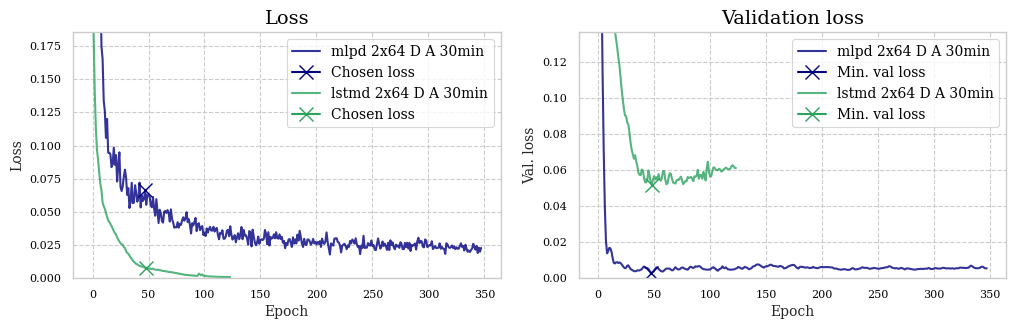


Training/loading models for dataset F
Model A
Resolution 30min

Columns before removal: 
Col. 0 : FYN0111 - Process Flow Rate
Col. 1 : TT0102_MA_Y - Process Inlet Temperature A
Col. 2 : TIC0101_CA_YX - Process Outlet Temperature A
Col. 3 : TT0104_MA_Y - Process Inlet Temperature B
Col. 4 : TIC0103_CA_YX - Process Outlet Temperature B
Col. 5 : TT0106_MA_Y - Process Inlet Temperature C
Col. 6 : TIC0105_CA_YX - Process Outlet Temperature C
Col. 7 : PDT0108_MA_Y - Process A Pressure Difference
Col. 8 : PDT0119_MA_Y - Process B Pressure Difference
Col. 9 : PDT0118_MA_Y - Process C Pressure Difference
Col. 10 : PIC0104_CA_YX - Separator Inlet Pressure
Col. 11 : TIC0425_CA_YX - Coolant Inlet Temperature
Col. 12 : TT0651_MA_Y - Coolant Outlet Temperature A
Col. 13 : TT0652_MA_Y - Coolant Outlet Temperature B
Col. 14 : TT0653_MA_Y - Coolant Outlet Temperature C
Col. 15 : TIC0101_CA_Y - Coolant Valve Opening A
Col. 16 : TIC0103_CA_Y - Coolant Valve Opening B
Col. 17 : TIC0105_CA_Y - Coolant Val

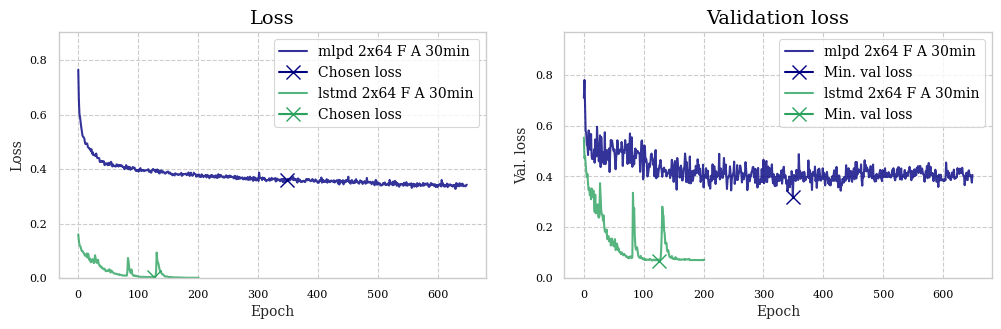


Training/loading models for dataset G
Model A
Resolution 30min

Columns before removal: 
Col. 0 : PDI0064 - Process Pressure Difference
Col. 1 : TI0066 - Process Outlet Temperature
Col. 2 : TZI0012 - Process Inlet Temperature
Col. 3 : FI0010 - Process Flow Rate
Col. 4 : TT0025 - Coolant Inlet Temperature
Col. 5 : TT0026 - Coolant Outlet Temperature
Col. 6 : PI0001 - Coolant Inlet Pressure
Col. 7 : FI0027 - Coolant Flow Rate
Col. 8 : TIC0022U - Coolant Valve Opening
Col. 9 : PDT0024 - Coolant Pressure Difference

Columns after removal: 
Col. 0 : TI0066 - Process Outlet Temperature
Col. 1 : TZI0012 - Process Inlet Temperature
Col. 2 : FI0010 - Process Flow Rate
Col. 3 : TT0025 - Coolant Inlet Temperature
Col. 4 : TT0026 - Coolant Outlet Temperature

Finding data between 2019-04-10 00:00:00 and 2019-08-01 00:00:00
Found 4708 rows

Finding data between 2017-01-01 00:00:00 and 2020-03-01 00:00:00
Found 49290 rows

Model mlpd 2x64 G A 30min was loaded from file
Model lstmd 2x64 G A 30min wa

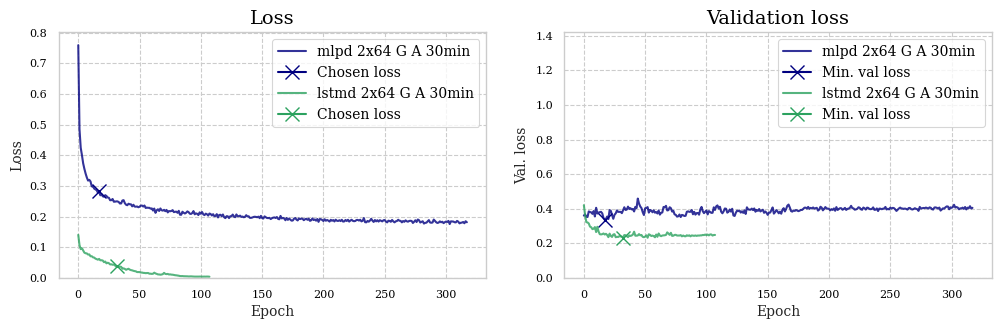


Predictions and deviations for dataset G
Model A
Resolution 30min

Columns before removal: 
Col. 0 : PDI0064 - Process Pressure Difference
Col. 1 : TI0066 - Process Outlet Temperature
Col. 2 : TZI0012 - Process Inlet Temperature
Col. 3 : FI0010 - Process Flow Rate
Col. 4 : TT0025 - Coolant Inlet Temperature
Col. 5 : TT0026 - Coolant Outlet Temperature
Col. 6 : PI0001 - Coolant Inlet Pressure
Col. 7 : FI0027 - Coolant Flow Rate
Col. 8 : TIC0022U - Coolant Valve Opening
Col. 9 : PDT0024 - Coolant Pressure Difference

Columns after removal: 
Col. 0 : TI0066 - Process Outlet Temperature
Col. 1 : TZI0012 - Process Inlet Temperature
Col. 2 : FI0010 - Process Flow Rate
Col. 3 : TT0025 - Coolant Inlet Temperature
Col. 4 : TT0026 - Coolant Outlet Temperature

Finding data between 2019-04-10 00:00:00 and 2019-08-01 00:00:00
Found 4708 rows

Finding data between 2017-01-01 00:00:00 and 2020-03-01 00:00:00
Found 49290 rows

Model prediction scores
+---------------------+-------------+------------

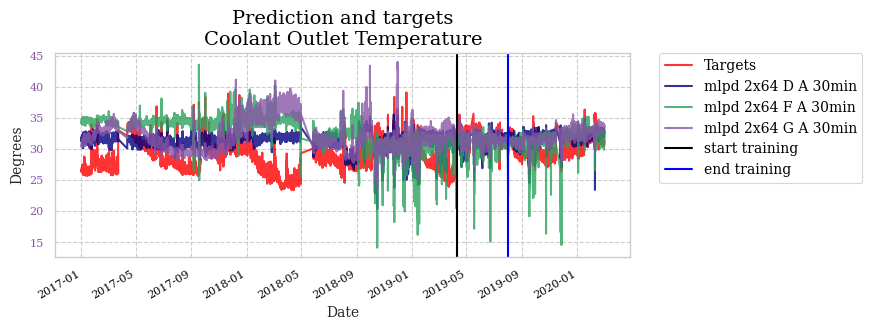

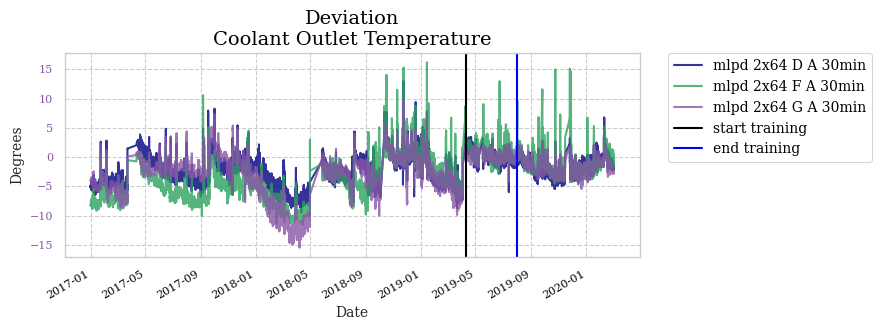

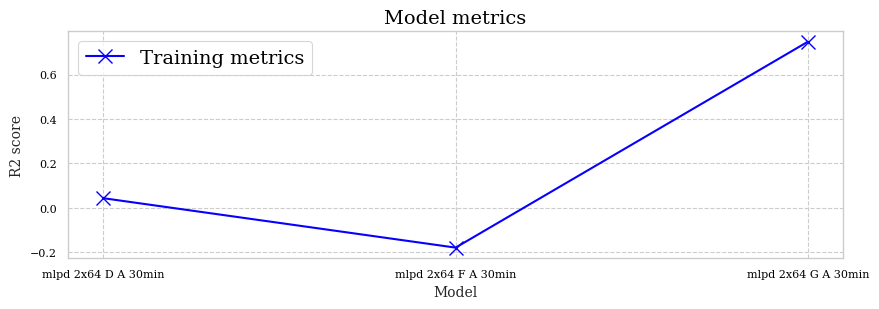


Predictions and deviations for dataset G
Model A
Resolution 30min

Columns before removal: 
Col. 0 : PDI0064 - Process Pressure Difference
Col. 1 : TI0066 - Process Outlet Temperature
Col. 2 : TZI0012 - Process Inlet Temperature
Col. 3 : FI0010 - Process Flow Rate
Col. 4 : TT0025 - Coolant Inlet Temperature
Col. 5 : TT0026 - Coolant Outlet Temperature
Col. 6 : PI0001 - Coolant Inlet Pressure
Col. 7 : FI0027 - Coolant Flow Rate
Col. 8 : TIC0022U - Coolant Valve Opening
Col. 9 : PDT0024 - Coolant Pressure Difference

Columns after removal: 
Col. 0 : TI0066 - Process Outlet Temperature
Col. 1 : TZI0012 - Process Inlet Temperature
Col. 2 : FI0010 - Process Flow Rate
Col. 3 : TT0025 - Coolant Inlet Temperature
Col. 4 : TT0026 - Coolant Outlet Temperature

Finding data between 2019-04-10 00:00:00 and 2019-08-01 00:00:00
Found 4708 rows

Finding data between 2017-01-01 00:00:00 and 2020-03-01 00:00:00
Found 49290 rows

Model prediction scores
+----------------------+-------------+-----------

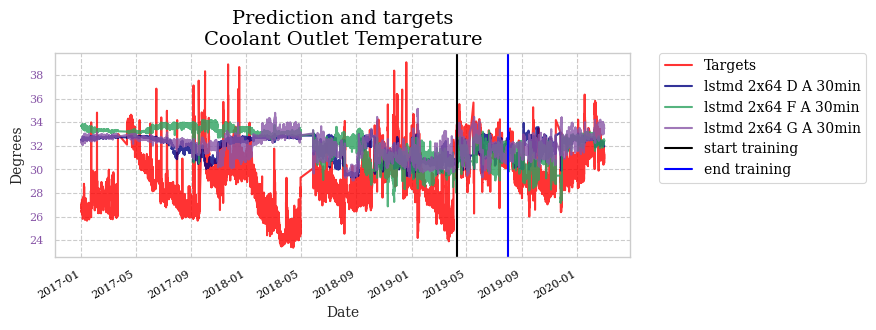

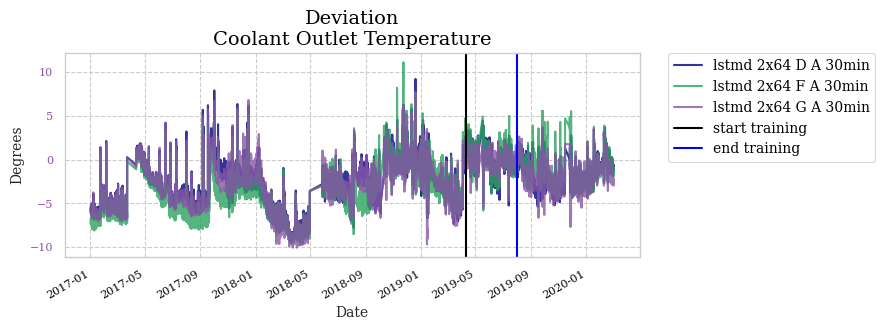

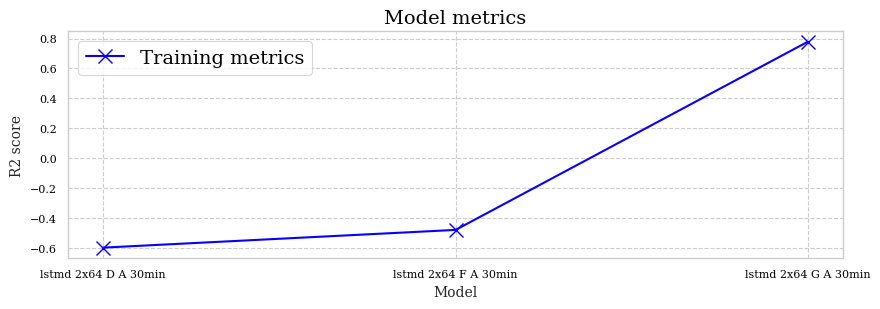


Predictions and deviations for dataset G
Model A
Resolution 30min

Columns before removal: 
Col. 0 : PDI0064 - Process Pressure Difference
Col. 1 : TI0066 - Process Outlet Temperature
Col. 2 : TZI0012 - Process Inlet Temperature
Col. 3 : FI0010 - Process Flow Rate
Col. 4 : TT0025 - Coolant Inlet Temperature
Col. 5 : TT0026 - Coolant Outlet Temperature
Col. 6 : PI0001 - Coolant Inlet Pressure
Col. 7 : FI0027 - Coolant Flow Rate
Col. 8 : TIC0022U - Coolant Valve Opening
Col. 9 : PDT0024 - Coolant Pressure Difference

Columns after removal: 
Col. 0 : TI0066 - Process Outlet Temperature
Col. 1 : TZI0012 - Process Inlet Temperature
Col. 2 : FI0010 - Process Flow Rate
Col. 3 : TT0025 - Coolant Inlet Temperature
Col. 4 : TT0026 - Coolant Outlet Temperature

Finding data between 2019-04-10 00:00:00 and 2019-08-01 00:00:00
Found 4708 rows

Finding data between 2017-01-01 00:00:00 and 2020-03-01 00:00:00
Found 49290 rows

Model prediction scores
+------------------+-------------+------------+
|

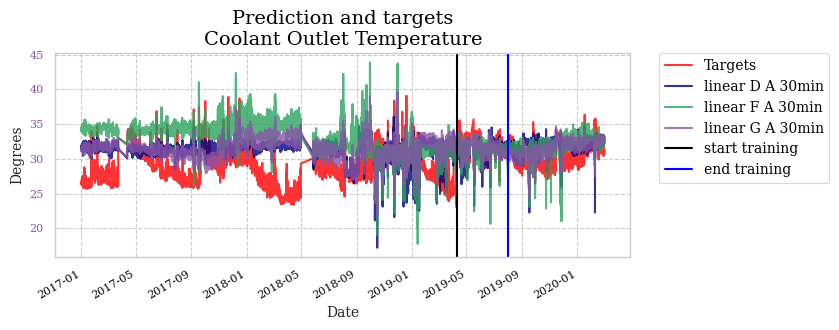

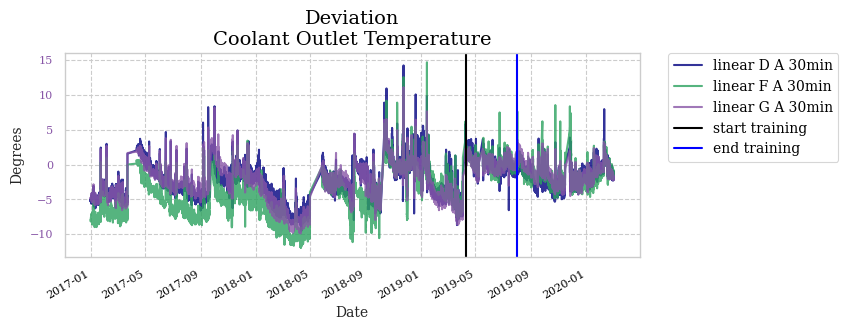

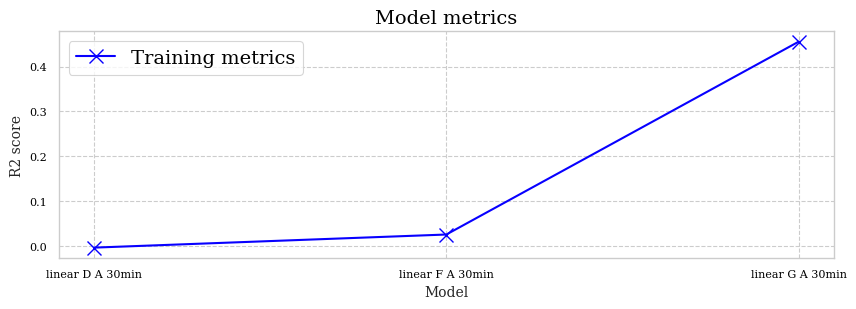

In [7]:
makePredictionsForModAndDir('A', 'G', dirrs, res)

## Discussion, Dataset G, model A

It is very difficult to evaluate the model performances on this dataset, because the Coolant Outlet Temperature itself is decreasing in a pattern very similar to what is  the expected fouling pattern. An engineer should perhaps using just parameter plots be able to see that the Coolant Outlet Temperature is reducing over time and suspect fouling is occuring. Even though the predictions of the models used are not particularly good, e.g. with rather low R2-scores, they end up having the same deviation pattern as the models trained on dataset G. This in itself is promising, although hardly evidence that models trained on different datasets can be used interchangeably.


Training/loading models for dataset D
Model B
Resolution 30min

Columns before removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20PT001 - Process Inlet Pressure
Col. 2 : 20FT001 - Process Flow Rate
Col. 3 : 20TT002 - Process Outlet Temperature
Col. 4 : 20PDT001 - Process Pressure Difference
Col. 5 : 50TT001 - Coolant Inlet Temperature
Col. 6 : 50PT001 - Coolant Inlet Pressure
Col. 7 : 50FT001 - Coolant Flow Rate
Col. 8 : 50TT002 - Coolant Outlet Temperature
Col. 9 : 50PDT001 - Coolant Pressure Difference
Col. 10 : 50TV001 - Coolant Valve Opening

Columns after removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20FT001 - Process Flow Rate
Col. 2 : 20TT002 - Process Outlet Temperature
Col. 3 : 50TT001 - Coolant Inlet Temperature
Col. 4 : 50TT002 - Coolant Outlet Temperature
Col. 5 : 50TV001 - Coolant Valve Opening

Finding data between 2020-01-01 00:00:00 and 2020-03-20 00:00:00
Found 315 rows

Finding data between 2020-01-01 00:00:00 and 2020-08-01 00:00:00


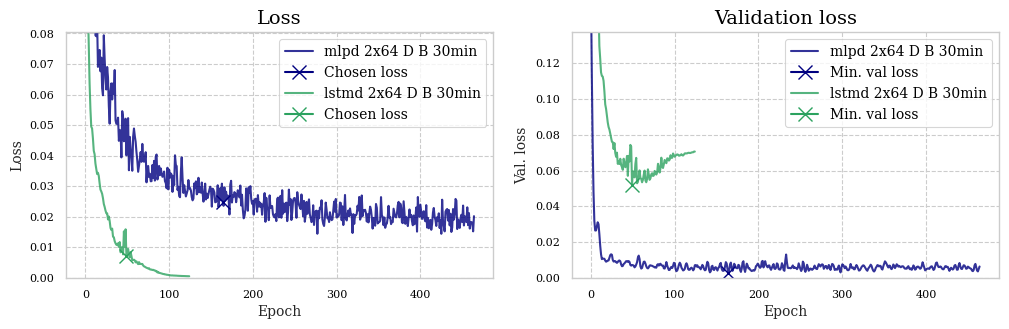


Training/loading models for dataset F
Model B
Resolution 30min

Columns before removal: 
Col. 0 : FYN0111 - Process Flow Rate
Col. 1 : TT0102_MA_Y - Process Inlet Temperature A
Col. 2 : TIC0101_CA_YX - Process Outlet Temperature A
Col. 3 : TT0104_MA_Y - Process Inlet Temperature B
Col. 4 : TIC0103_CA_YX - Process Outlet Temperature B
Col. 5 : TT0106_MA_Y - Process Inlet Temperature C
Col. 6 : TIC0105_CA_YX - Process Outlet Temperature C
Col. 7 : PDT0108_MA_Y - Process A Pressure Difference
Col. 8 : PDT0119_MA_Y - Process B Pressure Difference
Col. 9 : PDT0118_MA_Y - Process C Pressure Difference
Col. 10 : PIC0104_CA_YX - Separator Inlet Pressure
Col. 11 : TIC0425_CA_YX - Coolant Inlet Temperature
Col. 12 : TT0651_MA_Y - Coolant Outlet Temperature A
Col. 13 : TT0652_MA_Y - Coolant Outlet Temperature B
Col. 14 : TT0653_MA_Y - Coolant Outlet Temperature C
Col. 15 : TIC0101_CA_Y - Coolant Valve Opening A
Col. 16 : TIC0103_CA_Y - Coolant Valve Opening B
Col. 17 : TIC0105_CA_Y - Coolant Val

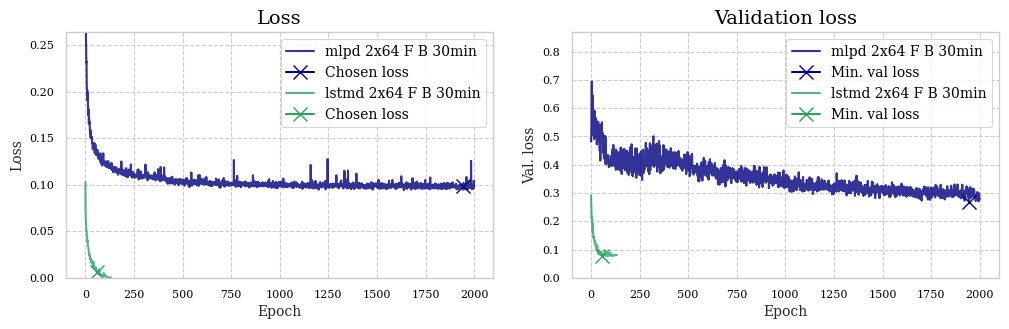


Training/loading models for dataset G
Model B
Resolution 30min

Columns before removal: 
Col. 0 : PDI0064 - Process Pressure Difference
Col. 1 : TI0066 - Process Outlet Temperature
Col. 2 : TZI0012 - Process Inlet Temperature
Col. 3 : FI0010 - Process Flow Rate
Col. 4 : TT0025 - Coolant Inlet Temperature
Col. 5 : TT0026 - Coolant Outlet Temperature
Col. 6 : PI0001 - Coolant Inlet Pressure
Col. 7 : FI0027 - Coolant Flow Rate
Col. 8 : TIC0022U - Coolant Valve Opening
Col. 9 : PDT0024 - Coolant Pressure Difference

Columns after removal: 
Col. 0 : TI0066 - Process Outlet Temperature
Col. 1 : TZI0012 - Process Inlet Temperature
Col. 2 : FI0010 - Process Flow Rate
Col. 3 : TT0025 - Coolant Inlet Temperature
Col. 4 : TT0026 - Coolant Outlet Temperature
Col. 5 : TIC0022U - Coolant Valve Opening

Finding data between 2019-04-10 00:00:00 and 2019-08-01 00:00:00
Found 4708 rows

Finding data between 2017-01-01 00:00:00 and 2020-03-01 00:00:00
Found 49290 rows

Model mlpd 2x64 G B 30min was load

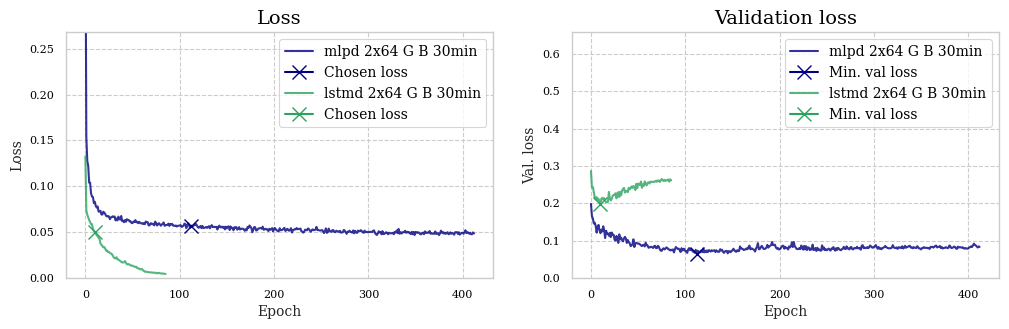


Predictions and deviations for dataset D
Model B
Resolution 30min

Columns before removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20PT001 - Process Inlet Pressure
Col. 2 : 20FT001 - Process Flow Rate
Col. 3 : 20TT002 - Process Outlet Temperature
Col. 4 : 20PDT001 - Process Pressure Difference
Col. 5 : 50TT001 - Coolant Inlet Temperature
Col. 6 : 50PT001 - Coolant Inlet Pressure
Col. 7 : 50FT001 - Coolant Flow Rate
Col. 8 : 50TT002 - Coolant Outlet Temperature
Col. 9 : 50PDT001 - Coolant Pressure Difference
Col. 10 : 50TV001 - Coolant Valve Opening

Columns after removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20FT001 - Process Flow Rate
Col. 2 : 20TT002 - Process Outlet Temperature
Col. 3 : 50TT001 - Coolant Inlet Temperature
Col. 4 : 50TT002 - Coolant Outlet Temperature
Col. 5 : 50TV001 - Coolant Valve Opening

Finding data between 2020-01-01 00:00:00 and 2020-03-20 00:00:00
Found 315 rows

Finding data between 2020-01-01 00:00:00 and 2020-08-01 00:00:

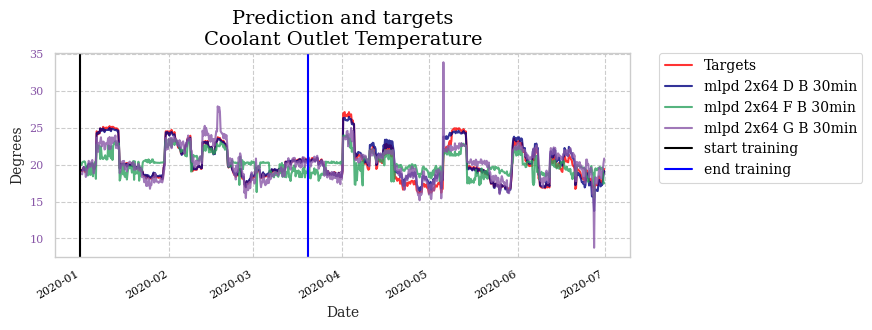

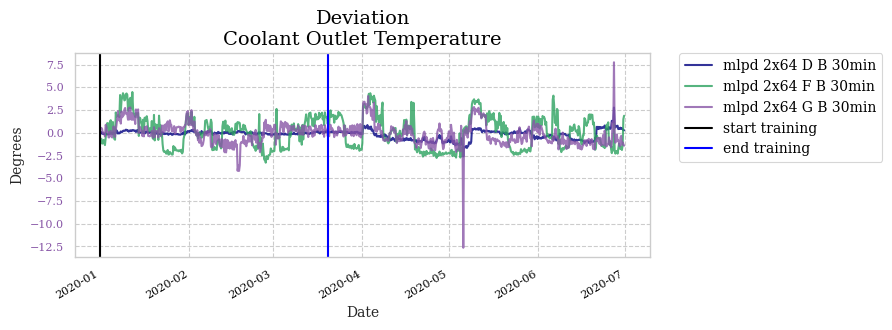

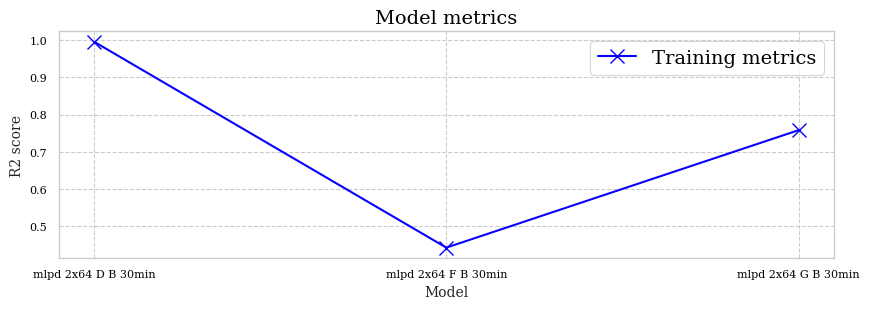


Predictions and deviations for dataset D
Model B
Resolution 30min

Columns before removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20PT001 - Process Inlet Pressure
Col. 2 : 20FT001 - Process Flow Rate
Col. 3 : 20TT002 - Process Outlet Temperature
Col. 4 : 20PDT001 - Process Pressure Difference
Col. 5 : 50TT001 - Coolant Inlet Temperature
Col. 6 : 50PT001 - Coolant Inlet Pressure
Col. 7 : 50FT001 - Coolant Flow Rate
Col. 8 : 50TT002 - Coolant Outlet Temperature
Col. 9 : 50PDT001 - Coolant Pressure Difference
Col. 10 : 50TV001 - Coolant Valve Opening

Columns after removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20FT001 - Process Flow Rate
Col. 2 : 20TT002 - Process Outlet Temperature
Col. 3 : 50TT001 - Coolant Inlet Temperature
Col. 4 : 50TT002 - Coolant Outlet Temperature
Col. 5 : 50TV001 - Coolant Valve Opening

Finding data between 2020-01-01 00:00:00 and 2020-03-20 00:00:00
Found 315 rows

Finding data between 2020-01-01 00:00:00 and 2020-08-01 00:00:

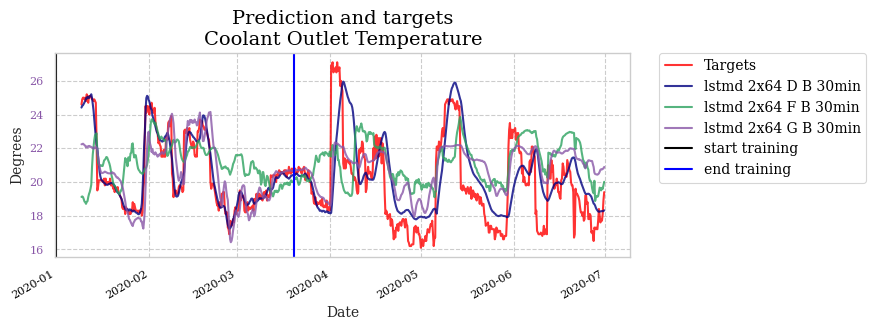

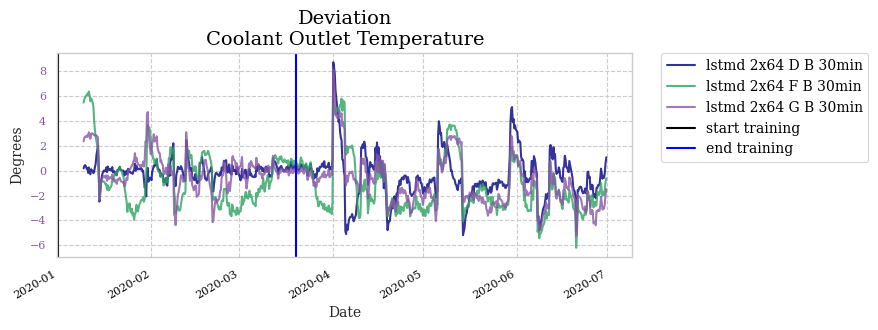

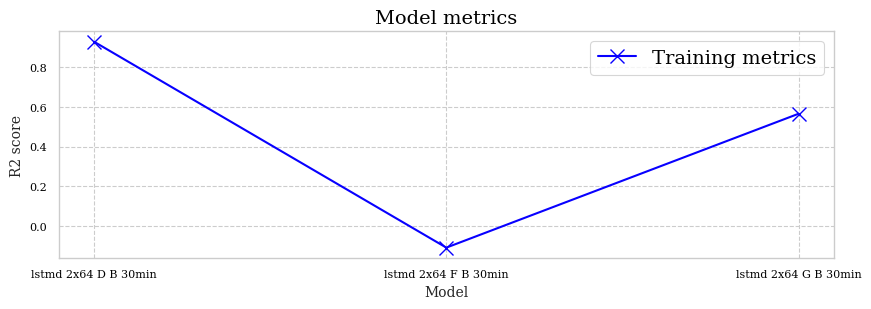


Predictions and deviations for dataset D
Model B
Resolution 30min

Columns before removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20PT001 - Process Inlet Pressure
Col. 2 : 20FT001 - Process Flow Rate
Col. 3 : 20TT002 - Process Outlet Temperature
Col. 4 : 20PDT001 - Process Pressure Difference
Col. 5 : 50TT001 - Coolant Inlet Temperature
Col. 6 : 50PT001 - Coolant Inlet Pressure
Col. 7 : 50FT001 - Coolant Flow Rate
Col. 8 : 50TT002 - Coolant Outlet Temperature
Col. 9 : 50PDT001 - Coolant Pressure Difference
Col. 10 : 50TV001 - Coolant Valve Opening

Columns after removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20FT001 - Process Flow Rate
Col. 2 : 20TT002 - Process Outlet Temperature
Col. 3 : 50TT001 - Coolant Inlet Temperature
Col. 4 : 50TT002 - Coolant Outlet Temperature
Col. 5 : 50TV001 - Coolant Valve Opening

Finding data between 2020-01-01 00:00:00 and 2020-03-20 00:00:00
Found 315 rows

Finding data between 2020-01-01 00:00:00 and 2020-08-01 00:00:

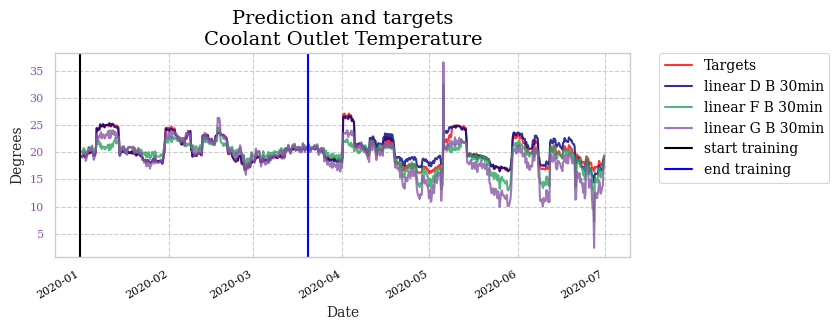

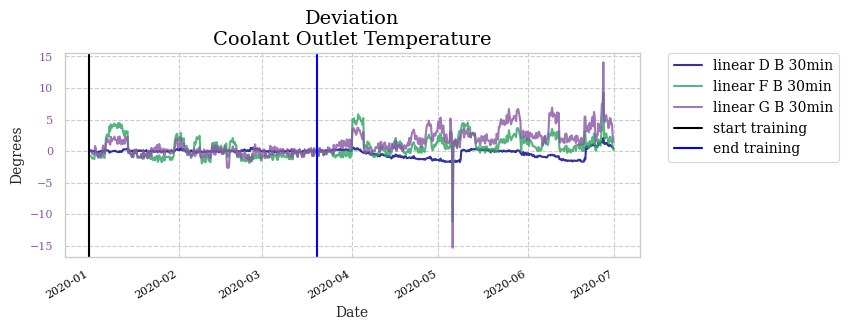

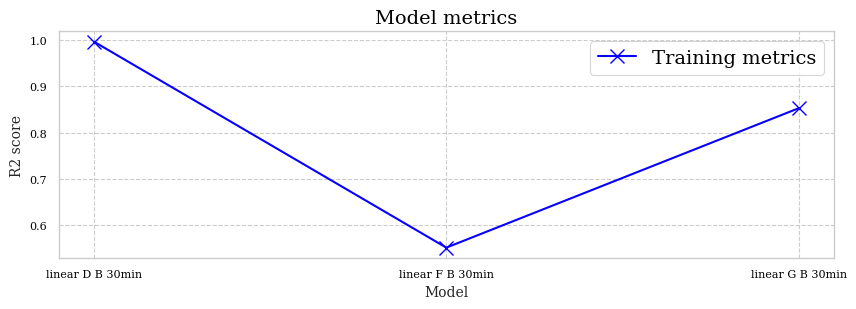

In [8]:
makePredictionsForModAndDir('B', 'D', dirrs, res)

## Discussion, Dataset D, model B

Once more, models trained on different datasets are not capable of predicting the expected fouling pattern


Training/loading models for dataset D
Model B
Resolution 30min

Columns before removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20PT001 - Process Inlet Pressure
Col. 2 : 20FT001 - Process Flow Rate
Col. 3 : 20TT002 - Process Outlet Temperature
Col. 4 : 20PDT001 - Process Pressure Difference
Col. 5 : 50TT001 - Coolant Inlet Temperature
Col. 6 : 50PT001 - Coolant Inlet Pressure
Col. 7 : 50FT001 - Coolant Flow Rate
Col. 8 : 50TT002 - Coolant Outlet Temperature
Col. 9 : 50PDT001 - Coolant Pressure Difference
Col. 10 : 50TV001 - Coolant Valve Opening

Columns after removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20FT001 - Process Flow Rate
Col. 2 : 20TT002 - Process Outlet Temperature
Col. 3 : 50TT001 - Coolant Inlet Temperature
Col. 4 : 50TT002 - Coolant Outlet Temperature
Col. 5 : 50TV001 - Coolant Valve Opening

Finding data between 2020-01-01 00:00:00 and 2020-03-20 00:00:00
Found 315 rows

Finding data between 2020-01-01 00:00:00 and 2020-08-01 00:00:00


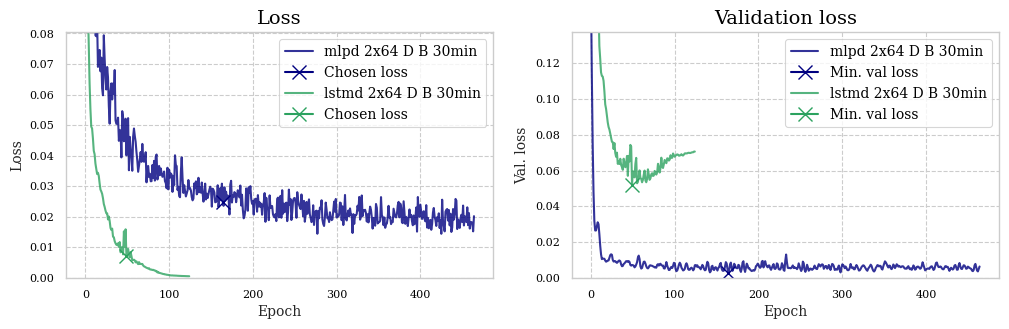


Training/loading models for dataset F
Model B
Resolution 30min

Columns before removal: 
Col. 0 : FYN0111 - Process Flow Rate
Col. 1 : TT0102_MA_Y - Process Inlet Temperature A
Col. 2 : TIC0101_CA_YX - Process Outlet Temperature A
Col. 3 : TT0104_MA_Y - Process Inlet Temperature B
Col. 4 : TIC0103_CA_YX - Process Outlet Temperature B
Col. 5 : TT0106_MA_Y - Process Inlet Temperature C
Col. 6 : TIC0105_CA_YX - Process Outlet Temperature C
Col. 7 : PDT0108_MA_Y - Process A Pressure Difference
Col. 8 : PDT0119_MA_Y - Process B Pressure Difference
Col. 9 : PDT0118_MA_Y - Process C Pressure Difference
Col. 10 : PIC0104_CA_YX - Separator Inlet Pressure
Col. 11 : TIC0425_CA_YX - Coolant Inlet Temperature
Col. 12 : TT0651_MA_Y - Coolant Outlet Temperature A
Col. 13 : TT0652_MA_Y - Coolant Outlet Temperature B
Col. 14 : TT0653_MA_Y - Coolant Outlet Temperature C
Col. 15 : TIC0101_CA_Y - Coolant Valve Opening A
Col. 16 : TIC0103_CA_Y - Coolant Valve Opening B
Col. 17 : TIC0105_CA_Y - Coolant Val

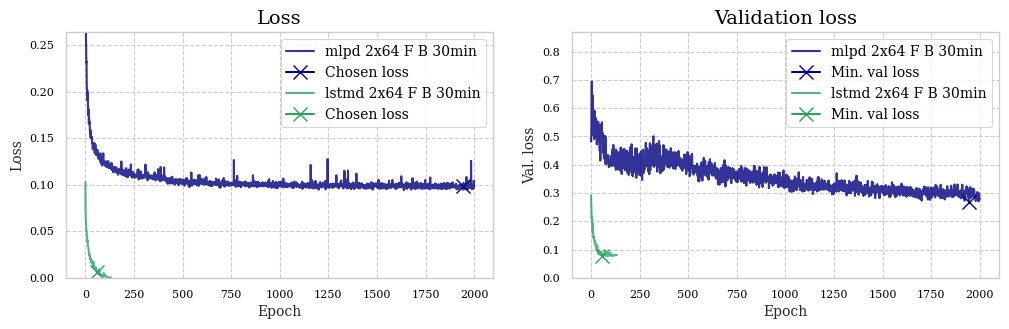


Training/loading models for dataset G
Model B
Resolution 30min

Columns before removal: 
Col. 0 : PDI0064 - Process Pressure Difference
Col. 1 : TI0066 - Process Outlet Temperature
Col. 2 : TZI0012 - Process Inlet Temperature
Col. 3 : FI0010 - Process Flow Rate
Col. 4 : TT0025 - Coolant Inlet Temperature
Col. 5 : TT0026 - Coolant Outlet Temperature
Col. 6 : PI0001 - Coolant Inlet Pressure
Col. 7 : FI0027 - Coolant Flow Rate
Col. 8 : TIC0022U - Coolant Valve Opening
Col. 9 : PDT0024 - Coolant Pressure Difference

Columns after removal: 
Col. 0 : TI0066 - Process Outlet Temperature
Col. 1 : TZI0012 - Process Inlet Temperature
Col. 2 : FI0010 - Process Flow Rate
Col. 3 : TT0025 - Coolant Inlet Temperature
Col. 4 : TT0026 - Coolant Outlet Temperature
Col. 5 : TIC0022U - Coolant Valve Opening

Finding data between 2019-04-10 00:00:00 and 2019-08-01 00:00:00
Found 4708 rows

Finding data between 2017-01-01 00:00:00 and 2020-03-01 00:00:00
Found 49290 rows

Model mlpd 2x64 G B 30min was load

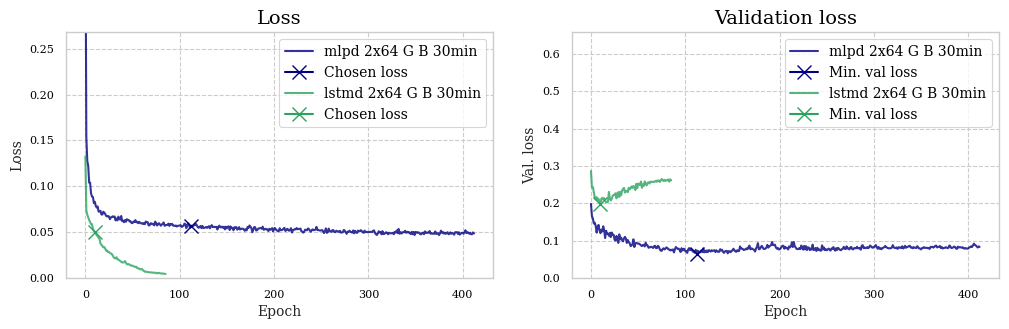


Predictions and deviations for dataset F
Model B
Resolution 30min

Columns before removal: 
Col. 0 : FYN0111 - Process Flow Rate
Col. 1 : TT0102_MA_Y - Process Inlet Temperature A
Col. 2 : TIC0101_CA_YX - Process Outlet Temperature A
Col. 3 : TT0104_MA_Y - Process Inlet Temperature B
Col. 4 : TIC0103_CA_YX - Process Outlet Temperature B
Col. 5 : TT0106_MA_Y - Process Inlet Temperature C
Col. 6 : TIC0105_CA_YX - Process Outlet Temperature C
Col. 7 : PDT0108_MA_Y - Process A Pressure Difference
Col. 8 : PDT0119_MA_Y - Process B Pressure Difference
Col. 9 : PDT0118_MA_Y - Process C Pressure Difference
Col. 10 : PIC0104_CA_YX - Separator Inlet Pressure
Col. 11 : TIC0425_CA_YX - Coolant Inlet Temperature
Col. 12 : TT0651_MA_Y - Coolant Outlet Temperature A
Col. 13 : TT0652_MA_Y - Coolant Outlet Temperature B
Col. 14 : TT0653_MA_Y - Coolant Outlet Temperature C
Col. 15 : TIC0101_CA_Y - Coolant Valve Opening A
Col. 16 : TIC0103_CA_Y - Coolant Valve Opening B
Col. 17 : TIC0105_CA_Y - Coolant 

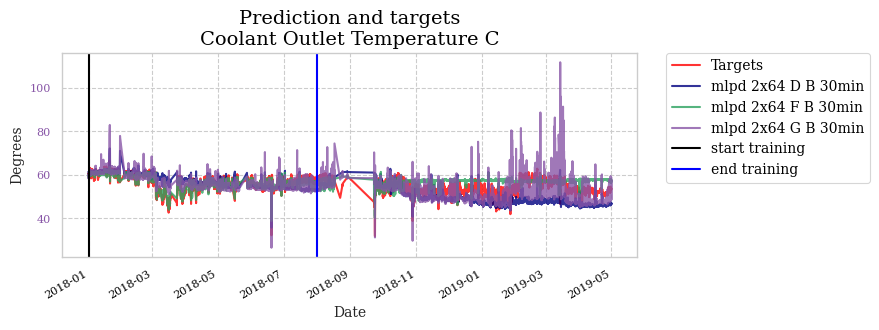

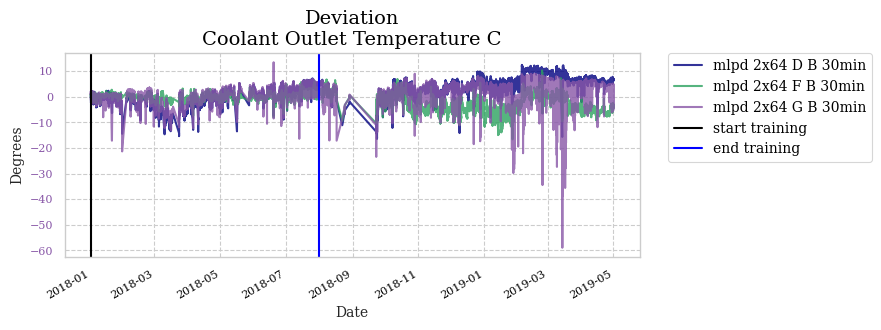

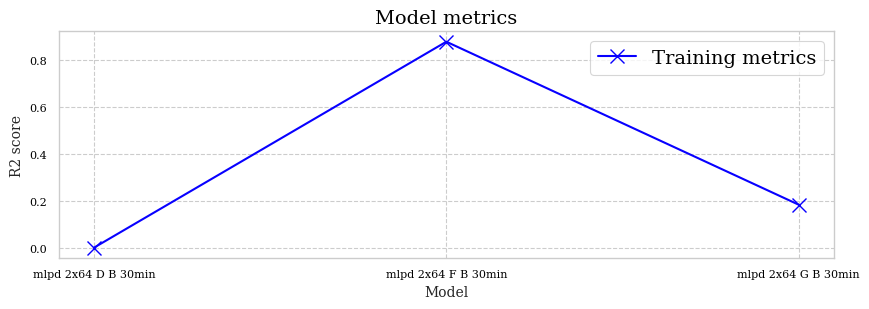


Predictions and deviations for dataset F
Model B
Resolution 30min

Columns before removal: 
Col. 0 : FYN0111 - Process Flow Rate
Col. 1 : TT0102_MA_Y - Process Inlet Temperature A
Col. 2 : TIC0101_CA_YX - Process Outlet Temperature A
Col. 3 : TT0104_MA_Y - Process Inlet Temperature B
Col. 4 : TIC0103_CA_YX - Process Outlet Temperature B
Col. 5 : TT0106_MA_Y - Process Inlet Temperature C
Col. 6 : TIC0105_CA_YX - Process Outlet Temperature C
Col. 7 : PDT0108_MA_Y - Process A Pressure Difference
Col. 8 : PDT0119_MA_Y - Process B Pressure Difference
Col. 9 : PDT0118_MA_Y - Process C Pressure Difference
Col. 10 : PIC0104_CA_YX - Separator Inlet Pressure
Col. 11 : TIC0425_CA_YX - Coolant Inlet Temperature
Col. 12 : TT0651_MA_Y - Coolant Outlet Temperature A
Col. 13 : TT0652_MA_Y - Coolant Outlet Temperature B
Col. 14 : TT0653_MA_Y - Coolant Outlet Temperature C
Col. 15 : TIC0101_CA_Y - Coolant Valve Opening A
Col. 16 : TIC0103_CA_Y - Coolant Valve Opening B
Col. 17 : TIC0105_CA_Y - Coolant 

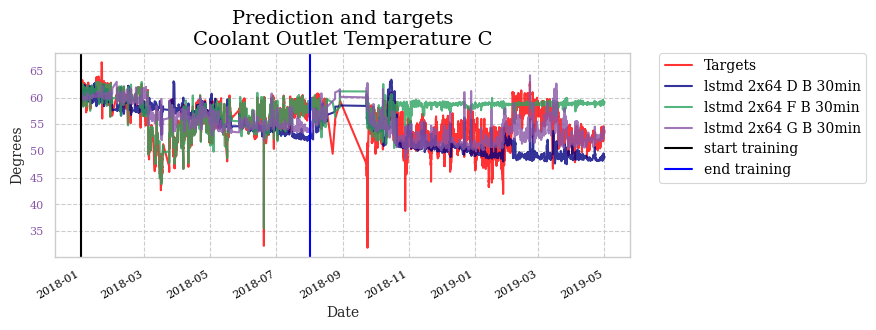

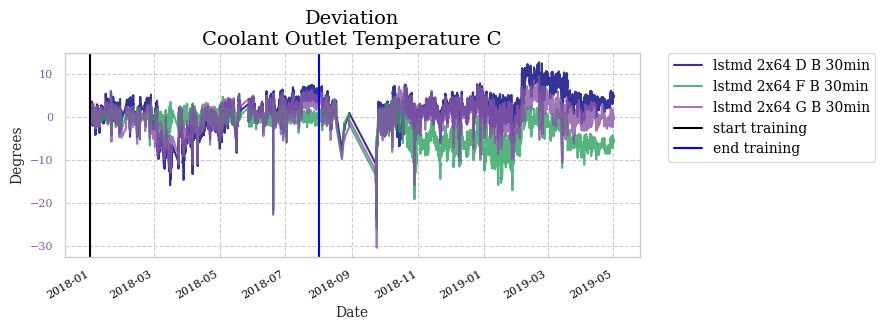

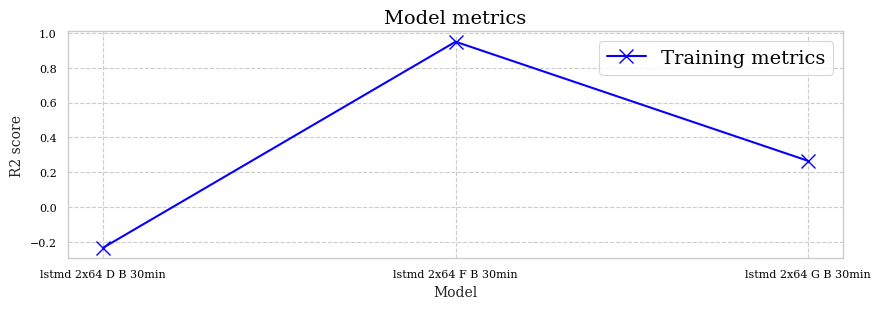


Predictions and deviations for dataset F
Model B
Resolution 30min

Columns before removal: 
Col. 0 : FYN0111 - Process Flow Rate
Col. 1 : TT0102_MA_Y - Process Inlet Temperature A
Col. 2 : TIC0101_CA_YX - Process Outlet Temperature A
Col. 3 : TT0104_MA_Y - Process Inlet Temperature B
Col. 4 : TIC0103_CA_YX - Process Outlet Temperature B
Col. 5 : TT0106_MA_Y - Process Inlet Temperature C
Col. 6 : TIC0105_CA_YX - Process Outlet Temperature C
Col. 7 : PDT0108_MA_Y - Process A Pressure Difference
Col. 8 : PDT0119_MA_Y - Process B Pressure Difference
Col. 9 : PDT0118_MA_Y - Process C Pressure Difference
Col. 10 : PIC0104_CA_YX - Separator Inlet Pressure
Col. 11 : TIC0425_CA_YX - Coolant Inlet Temperature
Col. 12 : TT0651_MA_Y - Coolant Outlet Temperature A
Col. 13 : TT0652_MA_Y - Coolant Outlet Temperature B
Col. 14 : TT0653_MA_Y - Coolant Outlet Temperature C
Col. 15 : TIC0101_CA_Y - Coolant Valve Opening A
Col. 16 : TIC0103_CA_Y - Coolant Valve Opening B
Col. 17 : TIC0105_CA_Y - Coolant 

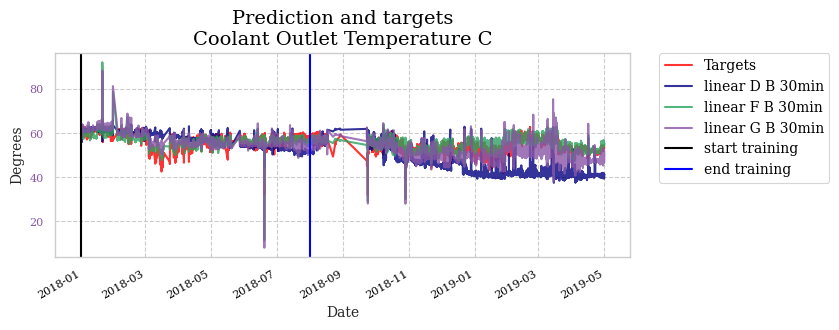

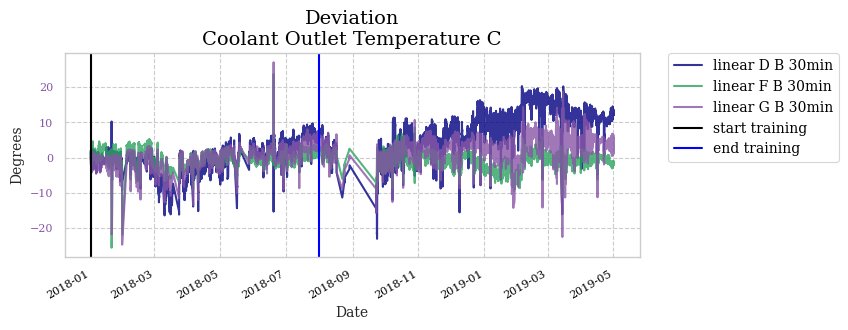

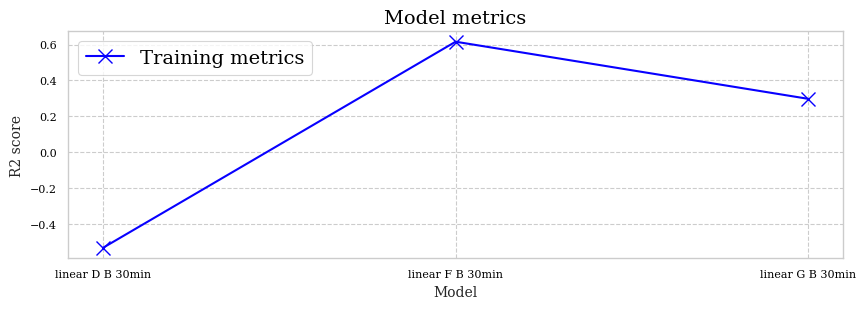

In [9]:
makePredictionsForModAndDir('B', 'F', dirrs, res)

## Discussion, Dataset F, model B

Models trained on dataset D appear to make illogical predictions in general. The models trained on dataset G perform surprisingly well with regards to R2-score on the training data. The performance on the test data is extremely difficult to interpret. Especially the MLP show large variations in prediction throughout the testing period. Meanwhile, the linear model has a prediction curve somewhat similar to that of the model trained on dataset F, however also with significant variation. It appears there may be some promise in the use of MLPs or Linear models trained on different models using Coolant Valve Opening as a feature, but no concrete evidence that this is sensible or feasible. 


Training/loading models for dataset D
Model B
Resolution 30min

Columns before removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20PT001 - Process Inlet Pressure
Col. 2 : 20FT001 - Process Flow Rate
Col. 3 : 20TT002 - Process Outlet Temperature
Col. 4 : 20PDT001 - Process Pressure Difference
Col. 5 : 50TT001 - Coolant Inlet Temperature
Col. 6 : 50PT001 - Coolant Inlet Pressure
Col. 7 : 50FT001 - Coolant Flow Rate
Col. 8 : 50TT002 - Coolant Outlet Temperature
Col. 9 : 50PDT001 - Coolant Pressure Difference
Col. 10 : 50TV001 - Coolant Valve Opening

Columns after removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20FT001 - Process Flow Rate
Col. 2 : 20TT002 - Process Outlet Temperature
Col. 3 : 50TT001 - Coolant Inlet Temperature
Col. 4 : 50TT002 - Coolant Outlet Temperature
Col. 5 : 50TV001 - Coolant Valve Opening

Finding data between 2020-01-01 00:00:00 and 2020-03-20 00:00:00
Found 315 rows

Finding data between 2020-01-01 00:00:00 and 2020-08-01 00:00:00


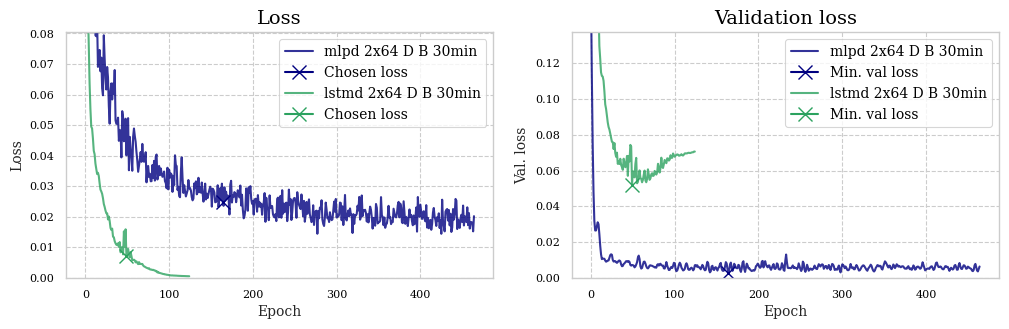


Training/loading models for dataset F
Model B
Resolution 30min

Columns before removal: 
Col. 0 : FYN0111 - Process Flow Rate
Col. 1 : TT0102_MA_Y - Process Inlet Temperature A
Col. 2 : TIC0101_CA_YX - Process Outlet Temperature A
Col. 3 : TT0104_MA_Y - Process Inlet Temperature B
Col. 4 : TIC0103_CA_YX - Process Outlet Temperature B
Col. 5 : TT0106_MA_Y - Process Inlet Temperature C
Col. 6 : TIC0105_CA_YX - Process Outlet Temperature C
Col. 7 : PDT0108_MA_Y - Process A Pressure Difference
Col. 8 : PDT0119_MA_Y - Process B Pressure Difference
Col. 9 : PDT0118_MA_Y - Process C Pressure Difference
Col. 10 : PIC0104_CA_YX - Separator Inlet Pressure
Col. 11 : TIC0425_CA_YX - Coolant Inlet Temperature
Col. 12 : TT0651_MA_Y - Coolant Outlet Temperature A
Col. 13 : TT0652_MA_Y - Coolant Outlet Temperature B
Col. 14 : TT0653_MA_Y - Coolant Outlet Temperature C
Col. 15 : TIC0101_CA_Y - Coolant Valve Opening A
Col. 16 : TIC0103_CA_Y - Coolant Valve Opening B
Col. 17 : TIC0105_CA_Y - Coolant Val

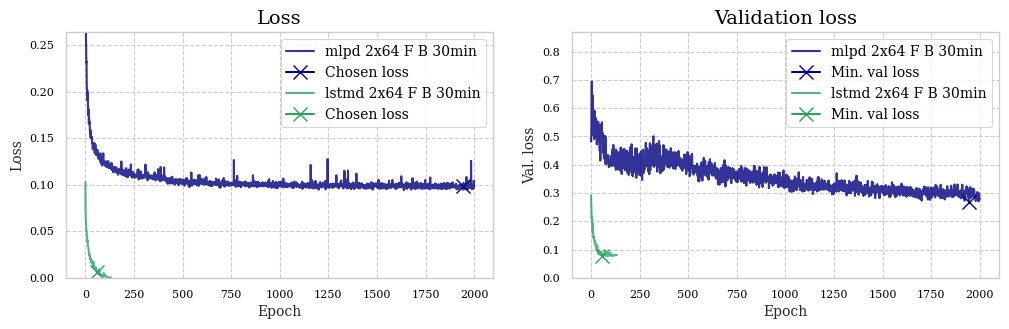


Training/loading models for dataset G
Model B
Resolution 30min

Columns before removal: 
Col. 0 : PDI0064 - Process Pressure Difference
Col. 1 : TI0066 - Process Outlet Temperature
Col. 2 : TZI0012 - Process Inlet Temperature
Col. 3 : FI0010 - Process Flow Rate
Col. 4 : TT0025 - Coolant Inlet Temperature
Col. 5 : TT0026 - Coolant Outlet Temperature
Col. 6 : PI0001 - Coolant Inlet Pressure
Col. 7 : FI0027 - Coolant Flow Rate
Col. 8 : TIC0022U - Coolant Valve Opening
Col. 9 : PDT0024 - Coolant Pressure Difference

Columns after removal: 
Col. 0 : TI0066 - Process Outlet Temperature
Col. 1 : TZI0012 - Process Inlet Temperature
Col. 2 : FI0010 - Process Flow Rate
Col. 3 : TT0025 - Coolant Inlet Temperature
Col. 4 : TT0026 - Coolant Outlet Temperature
Col. 5 : TIC0022U - Coolant Valve Opening

Finding data between 2019-04-10 00:00:00 and 2019-08-01 00:00:00
Found 4708 rows

Finding data between 2017-01-01 00:00:00 and 2020-03-01 00:00:00
Found 49290 rows

Model mlpd 2x64 G B 30min was load

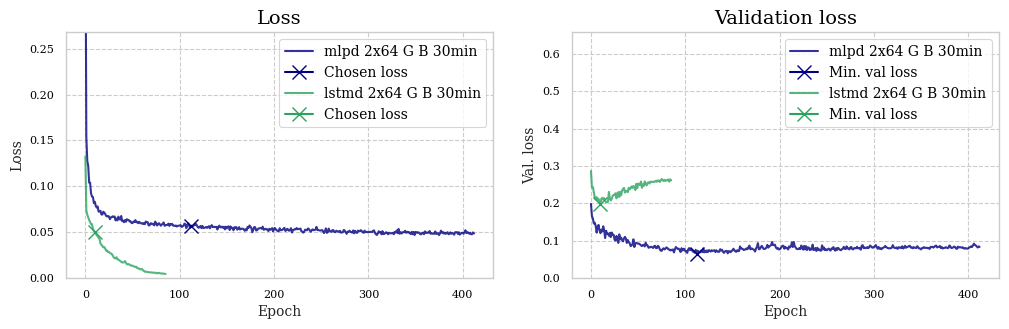


Predictions and deviations for dataset G
Model B
Resolution 30min

Columns before removal: 
Col. 0 : PDI0064 - Process Pressure Difference
Col. 1 : TI0066 - Process Outlet Temperature
Col. 2 : TZI0012 - Process Inlet Temperature
Col. 3 : FI0010 - Process Flow Rate
Col. 4 : TT0025 - Coolant Inlet Temperature
Col. 5 : TT0026 - Coolant Outlet Temperature
Col. 6 : PI0001 - Coolant Inlet Pressure
Col. 7 : FI0027 - Coolant Flow Rate
Col. 8 : TIC0022U - Coolant Valve Opening
Col. 9 : PDT0024 - Coolant Pressure Difference

Columns after removal: 
Col. 0 : TI0066 - Process Outlet Temperature
Col. 1 : TZI0012 - Process Inlet Temperature
Col. 2 : FI0010 - Process Flow Rate
Col. 3 : TT0025 - Coolant Inlet Temperature
Col. 4 : TT0026 - Coolant Outlet Temperature
Col. 5 : TIC0022U - Coolant Valve Opening

Finding data between 2019-04-10 00:00:00 and 2019-08-01 00:00:00
Found 4708 rows

Finding data between 2017-01-01 00:00:00 and 2020-03-01 00:00:00
Found 49290 rows

Model prediction scores
+------

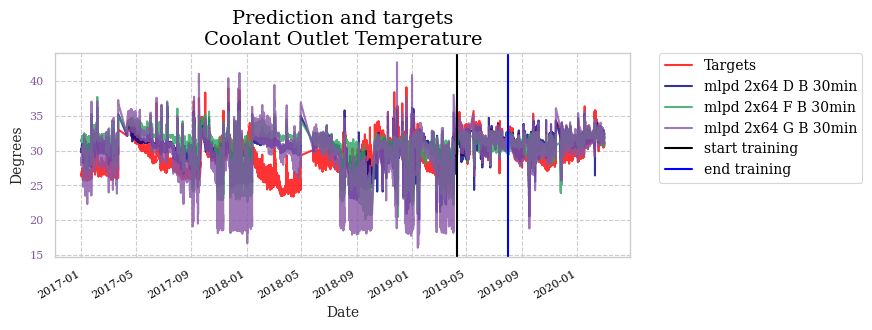

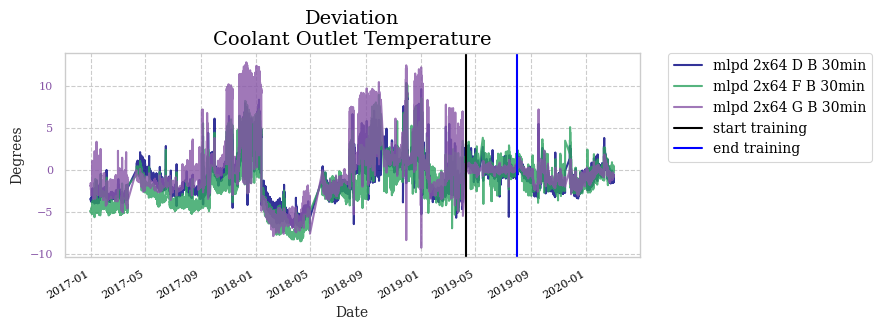

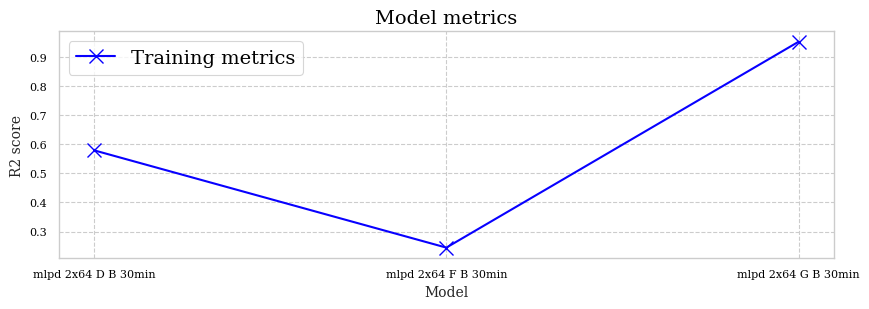


Predictions and deviations for dataset G
Model B
Resolution 30min

Columns before removal: 
Col. 0 : PDI0064 - Process Pressure Difference
Col. 1 : TI0066 - Process Outlet Temperature
Col. 2 : TZI0012 - Process Inlet Temperature
Col. 3 : FI0010 - Process Flow Rate
Col. 4 : TT0025 - Coolant Inlet Temperature
Col. 5 : TT0026 - Coolant Outlet Temperature
Col. 6 : PI0001 - Coolant Inlet Pressure
Col. 7 : FI0027 - Coolant Flow Rate
Col. 8 : TIC0022U - Coolant Valve Opening
Col. 9 : PDT0024 - Coolant Pressure Difference

Columns after removal: 
Col. 0 : TI0066 - Process Outlet Temperature
Col. 1 : TZI0012 - Process Inlet Temperature
Col. 2 : FI0010 - Process Flow Rate
Col. 3 : TT0025 - Coolant Inlet Temperature
Col. 4 : TT0026 - Coolant Outlet Temperature
Col. 5 : TIC0022U - Coolant Valve Opening

Finding data between 2019-04-10 00:00:00 and 2019-08-01 00:00:00
Found 4708 rows

Finding data between 2017-01-01 00:00:00 and 2020-03-01 00:00:00
Found 49290 rows

Model prediction scores
+------

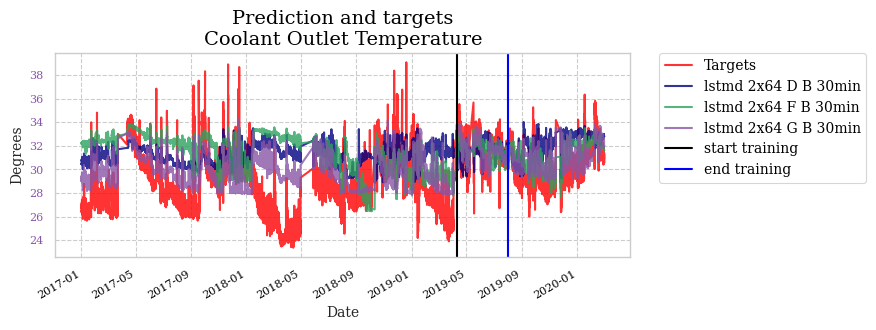

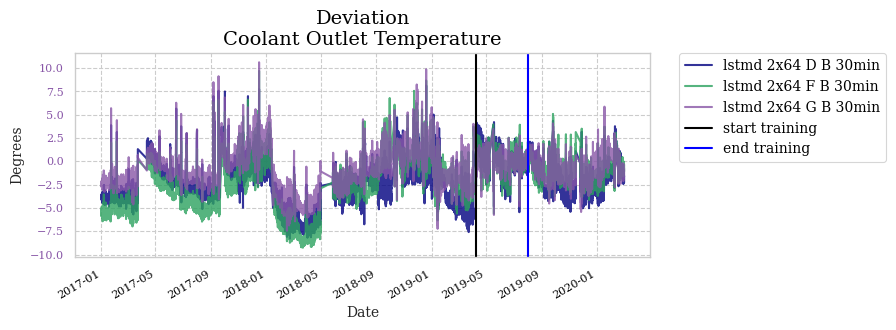

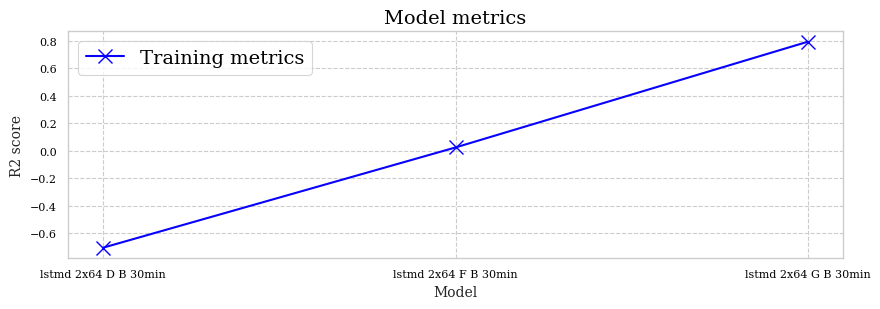


Predictions and deviations for dataset G
Model B
Resolution 30min

Columns before removal: 
Col. 0 : PDI0064 - Process Pressure Difference
Col. 1 : TI0066 - Process Outlet Temperature
Col. 2 : TZI0012 - Process Inlet Temperature
Col. 3 : FI0010 - Process Flow Rate
Col. 4 : TT0025 - Coolant Inlet Temperature
Col. 5 : TT0026 - Coolant Outlet Temperature
Col. 6 : PI0001 - Coolant Inlet Pressure
Col. 7 : FI0027 - Coolant Flow Rate
Col. 8 : TIC0022U - Coolant Valve Opening
Col. 9 : PDT0024 - Coolant Pressure Difference

Columns after removal: 
Col. 0 : TI0066 - Process Outlet Temperature
Col. 1 : TZI0012 - Process Inlet Temperature
Col. 2 : FI0010 - Process Flow Rate
Col. 3 : TT0025 - Coolant Inlet Temperature
Col. 4 : TT0026 - Coolant Outlet Temperature
Col. 5 : TIC0022U - Coolant Valve Opening

Finding data between 2019-04-10 00:00:00 and 2019-08-01 00:00:00
Found 4708 rows

Finding data between 2017-01-01 00:00:00 and 2020-03-01 00:00:00
Found 49290 rows

Model prediction scores
+------

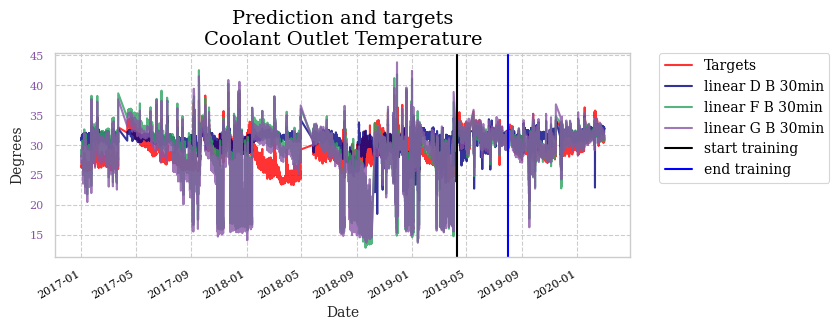

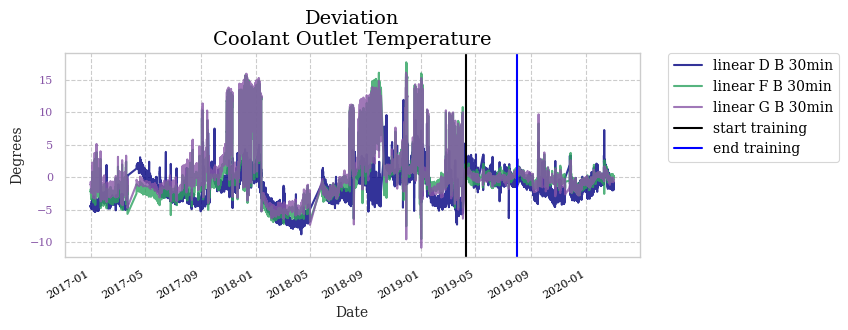

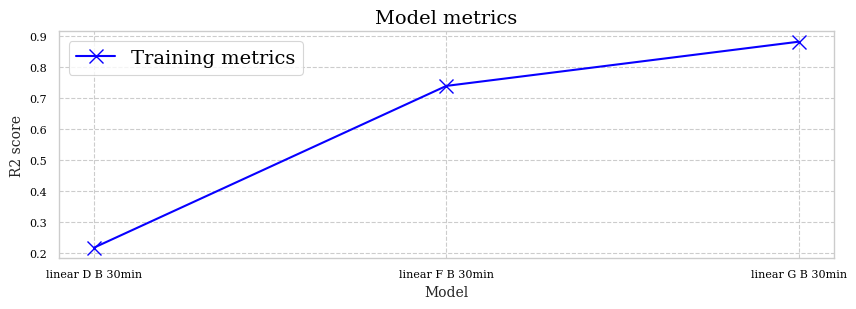

In [10]:
makePredictionsForModAndDir('B', 'G', dirrs, res)

## Discussion, Dataset G, model B

These models appear much more promising. For the MLP models, even though the deviation during the training phase is much larger than for the model trained on dataset G, models trained on dataset D and F actually show less signs of overfitting to the valve opening value than the model trained on dataset G. All LSTM models show almost the same prediction pattern, although with some static difference. Because changes in deviation are more interesting than static deviation, such predictions could still be useful as a fouling indicatior. The deviation curves have very similar patterns. The linear models seem to have much of the same valve opening overfitting problems.

# Conclusion

Performing predictions with models trained on different datasets appears to give unsatisfying results in general. Even so, there are some chases for which the pattern of prediction are quite similar. Perhaps predictions using models trained on different datasets can be utilized in cases where the processing plants are known to have many similarities. Further investigation is required in order to determine the usefulness of such models.

Training models in this manner may be particularly useful in cases where a dataset has no apparent training phase. For such cases, a model may be trained for a different dataset from a different processing plant where easily identifiable training phases are present. In such cases, this technique may be the only suitable manner to perform this form of regression predictions and inspection of deviation curves.